<a href="https://colab.research.google.com/github/mia19reynolds/FinalProject/blob/main/SynytheticStudentGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Synthetic Student Profile Generation

In this notebook, a data generation pipeline for generating a synthetic dataset of student profiles that mirror the characteristics and demographics of students in secondary schools in Derbyshire. The data used in this notebook is all source from the Department of Education (DoE). Distributions are drawn and normalised into 2 dimentional pivot tables. These are later used with iterative proportional fitting (IPF) to generate distributions across all 7 attributes to sample 41334  (number of pupils in secondary school within Derbyshire) student profiles. The distributions in the synthetic dataset are validated by working out the mean absolute error by comparing the attribute category cmbinations against the real data distributions.

Attendance is the generated through

This data is then used to train several models on the task of classification of CIN to see which model reacts the best to the data. It was found that the CatBoost Model did the best so this model is optimised and validated on the appropriate metrics.

# Imports

In [2]:
!pip install ipfn pyipf

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipfn import ipfn

## Normalize Master Dictionaries

In [4]:
# Labels in master order:
ethnicities_master = [
    "White - White British",
    "White - Any other White background",
    "Unclassified",
    "Mixed - White and Black Caribbean",
    "Mixed - White and Asian",
    "Mixed - Any other Mixed background",
    "Asian - Indian",
    "Black - Black African",
    "Asian - Chinese",
    "Mixed - White and Black African",
    "Asian - Any other Asian background",
    "Any other ethnic group",
    "Asian - Pakistani",
    "White - Irish",
    "Black - Any other Black background",
    "Black - Black Caribbean",
    "White - Gypsy/Roma",
    "Asian - Bangladeshi",
    "White - Traveller of Irish heritage"
]

# Map raw variant into one of those:
raw_to_master = {
    # White British
    "English / Welsh / Scottish / Northern Irish / British":"White - White British",
    "White - White British":"White - White British",
    "white_white_british":"White - White British",
    "white_british":"White - White British",
    'White British':"White - White British",

    # White other
    "Any other White background":"White - Any other White background",
    "White - Any other White background":"White - Any other White background",
    "white_any_other_white_background":"White - Any other White background",
    "any_other_white_background":"White - Any other White background",
    'Any other white background':"White - Any other White background",

    # Unclassified
    "Ethnicity Unclassified":"Unclassified",
    "Unclassified":"Unclassified",
    "unclassified":"Unclassified",

    # Mixed - W&BC
    "White and Black Caribbean":"Mixed - White and Black Caribbean",
    "Mixed - White and Black Caribbean":"Mixed - White and Black Caribbean",
    "mixed_white_and_black_caribbean":"Mixed - White and Black Caribbean",
    "Mixed - White and Black Carribean":"Mixed - White and Black Caribbean",
    "white_and_black_caribbean":"Mixed - White and Black Caribbean",
    "Mixed - White and Black Carribean":"Mixed - White and Black Caribbean",
    'White and Black Caribbean':"Mixed - White and Black Caribbean",

    # Mixed - W&A
    "White and Asian":"Mixed - White and Asian",
    "Mixed - White and Asian":"Mixed - White and Asian",
    "mixed_white_and_asian":"Mixed - White and Asian",
    "white_and_asian":"Mixed - White and Asian",

    # Mixed - other
    "Any other Mixed / Multiple ethnic background":"Mixed - Any other Mixed background",
    "Mixed - Any other Mixed background":"Mixed - Any other Mixed background",
    "mixed_any_other_mixed_background":"Mixed - Any other Mixed background",
    "any_other_mixed_background":"Mixed - Any other Mixed background",
    'Any other Mixed background':"Mixed - Any other Mixed background",
    "Any other mixed background":"Mixed - Any other Mixed background",

    # Mixed - W&BA
    "White and Black African":"Mixed - White and Black African",
    "Mixed - White and Black African":"Mixed - White and Black African",
    "mixed_white_and_black_african":"Mixed - White and Black African",
    "white_and_black_african": "Mixed - White and Black African",
    'White and Black African': "Mixed - White and Black African",

    # Asian - Indian
    "Indian":"Asian - Indian",
    "Asian - Indian":"Asian - Indian",
    "asian_indian":"Asian - Indian",
    "indian":"Asian - Indian",

    # Asian - Chinese
    "Chinese":"Asian - Chinese",
    "Asian - Chinese":"Asian - Chinese",
    "asian_chinese":"Asian - Chinese",
    "chinese":"Asian - Chinese",

    # Asian - other
    "Any other Asian background":"Asian - Any other Asian background",
    "Asian - Any other Asian background":"Asian - Any other Asian background",
    "asian_any_other_asian_background":"Asian - Any other Asian background",
    "any_other_asian_background":"Asian - Any other Asian background",

    # Asian -
    "Pakistani":"Asian - Pakistani",
    "Asian - Pakistani":"Asian - Pakistani",
    "asian_pakistani":"Asian - Pakistani",
    "pakistani":"Asian - Pakistani",

    # Asian - Bangladeshi
    "Bangladeshi":"Asian - Bangladeshi",
    "Asian - Bangladeshi":"Asian - Bangladeshi",
    "asian_bangaladeshi":"Asian - Bangladeshi",
    "bangladeshi":"Asian - Bangladeshi",
    "Asian - Bangaladeshi":"Asian - Bangladeshi",

    # Other ethnic group
    "Any other ethnic group":"Any other ethnic group",
    "Any other ethnic group":"Any other ethnic group",
    'Any Other Ethnic Group':"Any other ethnic group",
    "any_other_ethnic_group":"Any other ethnic group",

    # White - Irish
    "Irish":"White - Irish",
    "White - Irish":"White - Irish",
    "white_irish":"White - Irish",
    "irish":"White - Irish",
    "White Irish":"White - Irish",

    # Black - BA
    "African":"Black - Black African",
    "Black - Black African":"Black - Black African",
    "black_black_african":"Black - Black African",
    "black_african":"Black - Black African",
    'Black African':"Black - Black African",

    # Black -
    "Any other Black / African / Caribbean background":"Black - Any other Black background",
    "African":"Black - Black African",
    "Black - Any other Black background":"Black - Any other Black background",
    "black_any_other_black_background":"Black - Any other Black background",
    "any_other_black_background":"Black - Any other Black background",
    "Any other black background":"Black - Any other Black background",
    "Any other Black background":"Black - Any other Black background",

    # Black - BC
    "Caribbean":"Black - Black Caribbean",
    "Black - Black Caribbean":"Black - Black Caribbean",
    "black_caribbean":"Black - Black Caribbean",
    'Black Caribbean':"Black - Black Caribbean",

    # White - Gypsy/Roma
    "Gypsy / Roma":"White - Gypsy/Roma",
    "White - Gypsy/Roma":"White - Gypsy/Roma",
    "white_gypsy_roma":"White - Gypsy/Roma",
    "gypsy_roma":"White - Gypsy/Roma",
    "Gypsy Roma":"White - Gypsy/Roma",

    # Traveller
    "Traveller of Irish heritage":"White - Traveller of Irish heritage",
    "White - Traveller of Irish heritage":"White - Traveller of Irish heritage",
    "white_traveller_of_irish_heritage":"White - Traveller of Irish heritage",
    "traveller_of_irish_heritage":"White - Traveller of Irish heritage",
    "Traveller of Irish heritage":"White - Traveller of Irish heritage",
}


# Distributions

## Year Group and Age

### Number of Students - Gender by Year Group

In [5]:
sex_ncyear_df = pd.read_csv('/content/drive/MyDrive/pupildata/yrgp_sex_secondary_derbyshire.csv')

# Column names
print("Columns in the Derbyshire dataset:")
print(sex_ncyear_df.columns.tolist())

# Display
print("First few rows:")
sex_ncyear_df.head()


Columns in the Derbyshire dataset:
['time_period', 'time_identifier', 'geographic_level', 'country_code', 'country_name', 'region_name', 'region_code', 'old_la_code', 'la_name', 'new_la_code', 'phase_type_grouping', 'sex', 'ncyear', 'headcount']
First few rows:


,time_period,time_identifier,geographic_level,country_code,country_name,region_name,region_code,old_la_code,la_name,new_la_code,phase_type_grouping,sex,ncyear,headcount
0,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,State-funded secondary,Female,Year 10,3900
1,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,State-funded secondary,Female,Year 11,3956
2,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,State-funded secondary,Female,Year 7,4215
3,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,State-funded secondary,Female,Year 8,4178
4,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,State-funded secondary,Female,Year 9,4137


In [6]:
# Keep only the needed columns
df_gender_counts = sex_ncyear_df[['sex','ncyear','headcount']]

# Total by Genders
gender_counts = df_gender_counts.groupby('sex')['headcount'].sum()

print("Headcount by Gender:")
print(gender_counts.to_dict())

# Year Group counts within each Gender
yeargroup_counts = {}
for gender in df_gender_counts['sex'].unique():
    sub = df_gender_counts[df_gender_counts['sex']==gender]
    cnts = sub.groupby('ncyear')['headcount'].sum()
    yeargroup_counts[gender] = cnts.to_dict()

print("\nHeadcount by Year within each Gender:")
for gender, cnts in yeargroup_counts.items():
    print(f"\n{gender}:")
    for year, c in sorted(cnts.items()):
        print(f"  {year}: {c}")

Headcount by Gender:
{'Female': 20386, 'Male': 20948}

Headcount by Year within each Gender:

Female:
  Year 10: 3900
  Year 11: 3956
  Year 7: 4215
  Year 8: 4178
  Year 9: 4137

Male:
  Year 10: 4013
  Year 11: 4128
  Year 7: 4317
  Year 8: 4336
  Year 9: 4154


In [7]:
# Year Group×Gender pivot to get P(Gender | Year)
year_gender = sex_ncyear_df.pivot_table(
    index='ncyear',
    columns='sex',
    values='headcount',
    aggfunc='sum',
    fill_value=0
)

# Proportions for each Year Group
year_gender = year_gender.div(year_gender.sum(axis=1), axis=0)

print("P(Gender | Year):")
print(year_gender)

P(Gender | Year):
sex        Female      Male
ncyear                     
Year 10  0.492860  0.507140
Year 11  0.489362  0.510638
Year 7   0.494023  0.505977
Year 8   0.490721  0.509279
Year 9   0.498975  0.501025


In [8]:
year_gender = sex_ncyear_df.pivot_table(
    index='ncyear',
    columns='sex',
    values='headcount',
    aggfunc='sum',
    fill_value=0
)

print(year_gender)

sex      Female  Male
ncyear               
Year 10    3900  4013
Year 11    3956  4128
Year 7     4215  4317
Year 8     4178  4336
Year 9     4137  4154


## Ethnicity

### Number of Pupils per Ethnicity

In [9]:
ethnicity_df = pd.read_csv('/content/drive/MyDrive/pupildata/ethnicity_secondary_derbyshire.csv')
ethnicity_df.head()

,time_period,time_identifier,geographic_level,country_code,country_name,region_name,region_code,old_la_code,la_name,new_la_code,phase_type_grouping,ethnicity_minor,language,headcount
0,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,State-funded secondary,Any other ethnic group,Total,143
1,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,State-funded secondary,Asian - Any other Asian background,Total,201
2,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,State-funded secondary,Asian - Bangladeshi,Total,15
3,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,State-funded secondary,Asian - Chinese,Total,213
4,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,State-funded secondary,Asian - Indian,Total,387


In [10]:
ethnicity_df['Ethnicity'] = (
    ethnicity_df['ethnicity_minor']
      .map(raw_to_master)
      .fillna(ethnicity_df['ethnicity_minor'].astype(str))
)

In [11]:
eth_counts = (
    ethnicity_df
      .groupby('ethnicity_minor')['headcount']
      .sum()
      .reset_index()
      .sort_values('headcount', ascending=False)
      .rename(columns={'ethnicity_minor':'Ethnicity'})
)

eth_counts.head(20)

,Ethnicity,headcount
18,White - White British,41377
14,White - Any other White background,1279
13,Unclassified,519
12,Mixed - White and Black Caribbean,476
10,Mixed - White and Asian,465
9,Mixed - Any other Mixed background,414
4,Asian - Indian,387
7,Black - Black African,306
3,Asian - Chinese,213
11,Mixed - White and Black African,206


## FSM

### Number of pupils with FSM

In [12]:
fsm_df = pd.read_csv('/content/drive/MyDrive/pupildata/fsm_secondary_derbyshire.csv')

fsm_df.head()

,time_period,time_identifier,geographic_level,country_code,country_name,region_name,region_code,old_la_code,la_name,new_la_code,phase_type_grouping,fsm,headcount
0,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,State-funded secondary,known to be eligible for free school meals (us...,11089
1,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,State-funded secondary,number of pupils (used for FSM in Performance ...,41304


In [13]:
# Eligible vs non Eligible

pivot_fsm = fsm_df.pivot_table(
    index='fsm',
    values='headcount',
    aggfunc='sum'
).rename(index={
    'known to be eligible for free school meals (used for FSM in Performance Tables)':
        'FSM_Eligible',
    'number of pupils (used for FSM in Performance Tables)':
        'TOTAL_PUPILS'
})
pivot_fsm.index.name = 'FSM_Status'

eligible     = pivot_fsm.loc['FSM_Eligible','headcount']
total_pupils = pivot_fsm.loc['TOTAL_PUPILS','headcount']
not_eligible = total_pupils - eligible

# Build Pivot
clean_fsm = pd.Series({
    'FSM_Eligible':      eligible,
    'FSM_Not_Eligible':  not_eligible
}, name='headcount')

print("Clean FSM counts:")
print(clean_fsm, "\n")

Clean FSM counts:
FSM_Eligible        11089
FSM_Not_Eligible    30215
Name: headcount, dtype: int64 



### Number of pupils with FSM by Ethnicity

In [14]:
fsm_ethnicity_df = pd.read_csv('/content/drive/MyDrive/pupildata/fsm_ethnicity_secondary_derbyshire.csv')

fsm_ethnicity_df.head()

,time_period,time_identifier,geographic_level,country_code,country_name,region_name,region_code,old_la_code,la_name,new_la_code,characteristic_group,phase_type_grouping,characteristic,fsm_eligibility,number_of_pupils
0,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,Ethnicity Minor,State-funded secondary,Any other ethnic group,Known to be eligible for free school meals,51
1,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,Ethnicity Minor,State-funded secondary,Any other ethnic group,Not known to be eligible for free school meals,92
2,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,Ethnicity Minor,State-funded secondary,Asian - Any other Asian background,Known to be eligible for free school meals,31
3,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,Ethnicity Minor,State-funded secondary,Asian - Any other Asian background,Not known to be eligible for free school meals,170
4,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,Ethnicity Minor,State-funded secondary,Asian - Bangaladeshi,Known to be eligible for free school meals,5


In [15]:
fsm_ethnicity_df['characteristic'] = (
    fsm_ethnicity_df['characteristic']
      .astype(str)
      .map(raw_to_master)
)

# EthnicityxFSM counts pivot
pivot_eth = fsm_ethnicity_df.pivot_table(
    index='characteristic',
    columns='fsm_eligibility',
    values='number_of_pupils',
    aggfunc='sum',
    fill_value=0
).rename(columns={
    'Known to be eligible for free school meals':     'FSM_Eligible',
    'Not known to be eligible for free school meals': 'FSM_Not_Eligible'
})

# Display
pivot_eth


fsm_eligibility,FSM_Eligible,FSM_Not_Eligible
characteristic,,
Any other ethnic group,51,92
Asian - Any other Asian background,31,170
Asian - Bangladeshi,5,10
Asian - Chinese,21,192
Asian - Indian,35,352
Asian - Pakistani,25,95
Black - Any other Black background,17,54
Black - Black African,58,248
Black - Black Caribbean,19,16


### Number of Pupils with FSM by Year Group

In [16]:
fsm_yrgp_df = pd.read_csv('/content/drive/MyDrive/pupildata/fsm_yrgp_secondary_derbyshire.csv')

fsm_yrgp_df.head()

,time_period,time_identifier,geographic_level,country_code,country_name,region_name,region_code,old_la_code,la_name,new_la_code,characteristic_group,phase_type_grouping,characteristic,fsm_eligibility,number_of_pupils
0,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,NC year group,State-funded secondary,Year 10,Known to be eligible for free school meals,1970
1,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,NC year group,State-funded secondary,Year 10,Not known to be eligible for free school meals,5943
2,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,NC year group,State-funded secondary,Year 11,Known to be eligible for free school meals,1904
3,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,NC year group,State-funded secondary,Year 11,Not known to be eligible for free school meals,6180
4,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,NC year group,State-funded secondary,Year 7,Known to be eligible for free school meals,2573


In [17]:
# Pivot counts by Year Group × FSM status
pivot_yr = fsm_yrgp_df.pivot_table(
    index='characteristic',
    columns='fsm_eligibility',
    values='number_of_pupils',
    aggfunc='sum',
    fill_value=0
).rename(columns={
    'Known to be eligible for free school meals':     'FSM_Eligible',
    'Not known to be eligible for free school meals': 'FSM_Not_Eligible'
})

# Totals and Year Group Percentages
pivot_yr['total_pupils'] = pivot_yr['FSM_Eligible'] + pivot_yr['FSM_Not_Eligible']
pivot_yr['fsm_pct']      = (pivot_yr['FSM_Eligible'] / pivot_yr['total_pupils'] * 100).round(2)

# Overall FSM rate across all years
overall_elig = pivot_yr['FSM_Eligible'].sum()
overall_tot  = pivot_yr['total_pupils'].sum()
overall_rate = overall_elig / overall_tot * 100

# Display
print("FSM by Year Group (counts & percent):")
print(pivot_yr[['total_pupils','FSM_Eligible','fsm_pct']])

print(f"\nOverall FSM rate: {overall_rate:.2f}% ({overall_elig:,}/{overall_tot:,})")

FSM by Year Group (counts & percent):
fsm_eligibility  total_pupils  FSM_Eligible  fsm_pct
characteristic                                      
Year 10                  7913          1970    24.90
Year 11                  8084          1904    23.55
Year 7                   8532          2573    30.16
Year 8                   8514          2400    28.19
Year 9                   8291          2254    27.19

Overall FSM rate: 26.86% (11,101/41,334)


In [18]:
pivot_yr_fsm = pivot_yr.rename(index={
    'year_7':'Year 7','year_8':'Year 8','year_9':'Year 9',
    'year_10':'Year 10','year_11':'Year 11'
}).rename(columns={
    'FSM_eligible':      'FSM_Eligible',
    'total_pupils':      'TOTAL_PUPILS'
})

# Compute FSM_Not_Eligible by subtraction
pivot_yr_fsm['FSM_Not_Eligible'] = pivot_yr_fsm['TOTAL_PUPILS'] - pivot_yr_fsm['FSM_Eligible']

# Normalize to percentages
total_target = pivot_yr_fsm[['FSM_Eligible','FSM_Not_Eligible']].values.sum()
target_pct = (
    pivot_yr_fsm[['FSM_Eligible','FSM_Not_Eligible']]
      .div(total_target) * 100
).stack().rename('Target_%')

pivot_yr_fsm

fsm_eligibility,FSM_Eligible,FSM_Not_Eligible,TOTAL_PUPILS,fsm_pct
characteristic,,,,
Year 10,1970,5943,7913,24.90
Year 11,1904,6180,8084,23.55
Year 7,2573,5959,8532,30.16
Year 8,2400,6114,8514,28.19
Year 9,2254,6037,8291,27.19


## SEN

### Number of Students Labelled SEN

In [19]:
sen_df = pd.read_csv('/content/drive/MyDrive/pupildata/sen_gender_secondary_derbyshire.csv')
sen_df.head()

,time_period,time_identifier,geographic_level,country_code,country_name,region_name,region_code,old_la_code,la_name,new_la_code,breakdown_topic,phase_type_grouping,pupil_sen_status,primary_need,breakdown,pupil_count
0,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,Sex,State-funded secondary,EHC plans,Total,Male,1002
1,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,Sex,State-funded secondary,EHC plans,Total,Female,426
2,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,Sex,State-funded secondary,No SEN,Total,Male,18474
3,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,Sex,State-funded secondary,No SEN,Total,Female,20054
4,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,Sex,State-funded secondary,SEN Support,Total,Male,3756


In [20]:
# Overall SEN counts
sen_counts = sen_df.groupby('pupil_sen_status')['pupil_count'].sum()

# Percentages
total = sen_counts.sum()
sen_pct    = (sen_counts / total * 100).round(1)

# Display
result_sen = pd.DataFrame({
    'count' : sen_counts.astype(int),
    'percent': sen_pct
})
print(result_sen)

                  count  percent
pupil_sen_status                
EHC plans          1428      3.1
No SEN            38528     83.2
SEN Support        6375     13.8


### Number of Student Labelled SEN by Gender

In [21]:
pivot_sen_by_gen = sen_df.pivot_table(
    index='breakdown',
    columns='pupil_sen_status',
    values='pupil_count',
    aggfunc='sum',
    fill_value=0
)

# 3) Compute row-percentages within each gender
pct = pivot_sen_by_gen.div(pivot_sen_by_gen.sum(axis=1), axis=0).multiply(100).round(1)

# 4) Combine counts and percentages
combined = pd.DataFrame({
    f'{col} (count)'   : pivot_sen_by_gen[col] for col in pivot_sen_by_gen.columns
})
for col in pivot_sen_by_gen.columns:
    combined[f'{col} (%)'] = pct[col]

print("SEN status by Gender")
print(combined)

SEN status by Gender
           EHC plans (count)  No SEN (count)  SEN Support (count)  \
breakdown                                                           
Female                   426           20054                 2619   
Male                    1002           18474                 3756   

           EHC plans (%)  No SEN (%)  SEN Support (%)  
breakdown                                              
Female               1.8        86.8             11.3  
Male                 4.3        79.5             16.2  


### Number of Students Labelled SEN by Year Group

In [22]:
sen_yrgp_df = pd.read_csv('/content/drive/MyDrive/pupildata/sen_yrgp_secondary_derbyshire.csv')
sen_yrgp_df.head()

,time_period,time_identifier,geographic_level,country_code,country_name,region_name,region_code,old_la_code,la_name,new_la_code,phase_type_grouping,pupil_sen_status,primary_need,number_of_pupils,nc_year_7,nc_year_8,nc_year_9,nc_year_10,nc_year_11
0,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,State-funded secondary,No SEN,Total,38528,6886,6894,6785,6573,6731
1,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,State-funded secondary,SEN Support,Total,6375,1370,1356,1238,1056,1092
2,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,State-funded secondary,EHC plans,Total,1428,276,264,268,284,261


In [23]:
df = sen_yrgp_df

# Keep only necessary columns
year_cols = [c for c in df.columns if c.startswith('nc_year_')]
keep_cols = ['pupil_sen_status'] + year_cols
df2 = df[keep_cols].copy()

# Rename year group titles
rename_map = { f'nc_year_{n}': f'Year {n}' for n in range(7, 12) }
df2 = df2.rename(columns=rename_map)

df_long = df2.melt(
    id_vars='pupil_sen_status',
    var_name='Year_Group',
    value_name='headcount'
)

# Pivot year group by SEN
pivot_sen_by_year = df_long.pivot_table(
    index='Year_Group',
    columns='pupil_sen_status',
    values='headcount',
    aggfunc='sum',
    fill_value=0
)

# Correct year group order
pivot_sen_by_year = pivot_sen_by_year.reindex(
    ['Year 7','Year 8','Year 9','Year 10','Year 11']
)

# 7) Show the result
print("SEN counts by Year_Group:\n")
display(pivot_sen_by_year)

SEN counts by Year_Group:



pupil_sen_status,EHC plans,No SEN,SEN Support
Year_Group,,,
Year 7,276,6886,1370
Year 8,264,6894,1356
Year 9,268,6785,1238
Year 10,284,6573,1056
Year 11,261,6731,1092


### Number of Student Labelled SEN by Ethnicity

In [24]:
sen_eth_df = pd.read_csv('/content/drive/MyDrive/pupildata/sen_ethniticity_fsm_secondary_derbyshire.csv')
sen_eth_df.head()

,time_period,time_identifier,geographic_level,country_code,country_name,region_name,region_code,old_la_code,la_name,new_la_code,...,ethnicity_indian,ethnicity_pakistani,ethnicity_bangladeshi,ethnicity_any_other_asian_background,ethnicity_black_caribbean,ethnicity_black_african,ethnicity_any_other_black_background,ethnicity_chinese,ethnicity_any_other_ethnic_group,ethnicity_unclassified
0,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,...,3,2,0,4,1,3,3,1,2,26
1,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,...,21,12,1,15,7,14,4,17,15,65
2,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,...,363,106,14,182,27,289,64,195,126,428


In [25]:
df = sen_eth_df

# Find ethnicity columns
eth_cols = [c for c in df.columns if c.startswith('ethnicity_')]

# Keep only needed columns
df2 = df[['pupil_sen_status'] + eth_cols].copy()

# Melt into long form:
df_long = df2.melt(
    id_vars='pupil_sen_status',
    value_vars=eth_cols,
    var_name='ethnicity',
    value_name='headcount'
)

# Clean up the ethnicity names
df_long['ethnicity'] = df_long['ethnicity'].str.replace('^ethnicity_', '',
                                                      regex=True)
df_long['ethnicity'] = df_long['ethnicity'].map(raw_to_master)

# Create pivot table
pivot_sen_by_eth = df_long.pivot_table(
    index='pupil_sen_status',
    columns='ethnicity',
    values='headcount',
    aggfunc='sum',
    fill_value=0
).reindex(
        index=['EHC plans','No SEN','SEN Support'],
        columns=ethnicities_master,
        fill_value=0
    )

# Display
print("SEN counts by Ethnicity")
display(pivot_sen_by_eth)

SEN counts by Ethnicity


ethnicity,White - White British,White - Any other White background,Unclassified,Mixed - White and Black Caribbean,Mixed - White and Asian,Mixed - Any other Mixed background,Asian - Indian,Black - Black African,Asian - Chinese,Mixed - White and Black African,Asian - Any other Asian background,Any other ethnic group,Asian - Pakistani,White - Irish,Black - Any other Black background,Black - Black Caribbean,White - Gypsy/Roma,Asian - Bangladeshi,White - Traveller of Irish heritage
pupil_sen_status,,,,,,,,,,,,,,,,,,,
EHC plans,1320,17,26,15,12,11,3,3,1,5,4,2,2,0,3,1,2,0,1
No SEN,34179,1145,428,382,403,358,363,289,195,181,182,126,106,61,64,27,18,14,7
SEN Support,5878,117,65,79,50,45,21,14,17,20,15,15,12,10,4,7,2,1,3


In [26]:
pivot_sen_by_eth

ethnicity,White - White British,White - Any other White background,Unclassified,Mixed - White and Black Caribbean,Mixed - White and Asian,Mixed - Any other Mixed background,Asian - Indian,Black - Black African,Asian - Chinese,Mixed - White and Black African,Asian - Any other Asian background,Any other ethnic group,Asian - Pakistani,White - Irish,Black - Any other Black background,Black - Black Caribbean,White - Gypsy/Roma,Asian - Bangladeshi,White - Traveller of Irish heritage
pupil_sen_status,,,,,,,,,,,,,,,,,,,
EHC plans,1320,17,26,15,12,11,3,3,1,5,4,2,2,0,3,1,2,0,1
No SEN,34179,1145,428,382,403,358,363,289,195,181,182,126,106,61,64,27,18,14,7
SEN Support,5878,117,65,79,50,45,21,14,17,20,15,15,12,10,4,7,2,1,3


### Number of Pupils Labelled SEN by FSM Status

In [27]:
sen_fsm_df = pd.read_csv('/content/drive/MyDrive/pupildata/sen_ethniticity_fsm_secondary_derbyshire.csv')
sen_fsm_df.head()

,time_period,time_identifier,geographic_level,country_code,country_name,region_name,region_code,old_la_code,la_name,new_la_code,...,ethnicity_indian,ethnicity_pakistani,ethnicity_bangladeshi,ethnicity_any_other_asian_background,ethnicity_black_caribbean,ethnicity_black_african,ethnicity_any_other_black_background,ethnicity_chinese,ethnicity_any_other_ethnic_group,ethnicity_unclassified
0,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,...,3,2,0,4,1,3,3,1,2,26
1,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,...,21,12,1,15,7,14,4,17,15,65
2,202324,Academic year,Local authority,E92000001,England,East Midlands,E12000004,830,Derbyshire,E10000007,...,363,106,14,182,27,289,64,195,126,428


In [28]:
df = sen_fsm_df

# Keep only necessary columns
df2 = df[['pupil_sen_status', 'fsm_eligible', 'fsm_not_eligible']]

df_long = df2.melt(
    id_vars='pupil_sen_status',
    value_vars=['fsm_eligible', 'fsm_not_eligible'],
    var_name='fsm_eligibility',
    value_name='headcount'
)

# 5) Pivot so rows=FSM status, columns=SEN status
pivot_sen_by_fsm = df_long.pivot_table(
    index='fsm_eligibility',
    columns='pupil_sen_status',
    values='headcount',
    aggfunc='sum',
    fill_value=0
)

pivot_sen_by_fsm = pivot_sen_by_fsm.rename(index={
    'fsm_eligible':     'FSM_Eligible',
    'fsm_not_eligible': 'FSM_Not_Eligible'
})

print("SEN counts by FSM eligibility")
display(pivot_sen_by_fsm)

SEN counts by FSM eligibility


pupil_sen_status,EHC plans,No SEN,SEN Support
fsm_eligibility,,,
FSM_Eligible,635,8574,2437
FSM_Not_Eligible,793,29954,3938


## Suspensions

### Number of Students with one or more Suspensions

In [29]:
susp_df = pd.read_csv('/content/drive/MyDrive/pupildata/suspesnsions_gender_secondary_derbyshire.csv')
susp_df

,time_period,time_identifier,geographic_level,country_code,country_name,region_code,region_name,new_la_code,old_la_code,la_name,characteristic_group,education_phase,characteristic,headcount,one_plus_susp
0,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Sex,State-funded secondary,Sex male,23326,1244
1,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Sex,State-funded secondary,Sex female,23204,799


In [30]:
suspended = pd.Series({
    'Suspended':     susp_df['one_plus_susp'].sum(),
    'Not Suspended': susp_df['headcount'].sum() - susp_df['one_plus_susp'].sum()
})

# Turn into percents
total = suspended.sum()
percentage = (suspended / total * 100).round(1)

# Pivot table
overall_susp = pd.DataFrame({
    'count':   suspended.astype(int),
    'percent': percentage
})
print("Overall suspension status:")
print(overall_susp)

Overall suspension status:
               count  percent
Suspended       2043      4.4
Not Suspended  44487     95.6


### Number of Students with one or more Suspensions by Gender

In [31]:
# Filter to just Gender characteristics
df_sec = susp_df[
    (susp_df['characteristic_group'] == 'Sex')
].copy()

# Clean up the Gender label
df_sec['Gender'] = df_sec['characteristic'].str.replace('Sex ', '').str.capitalize()

# Total headcount and suspended counts by gender
agg = df_sec.groupby('Gender').agg(
    suspended =('one_plus_susp', 'sum'),
    total =('headcount',     'sum'),
)

# Not_suspended and percentages
agg['not_suspended'] = agg['total'] - agg['suspended']
agg['pct_suspended'] = (agg['suspended'] / agg['total'] * 100).round(1)
agg['pct_not_suspended']= (agg['not_suspended'] / agg['total'] * 100).round(1)

# Reorder & rename columns
# Counts
pivot_susp_gen_counts = agg[['not_suspended','suspended']].rename(columns={
    'not_suspended':'Not_Suspended_count',
    'suspended':'Suspended_count'
})

# Percentages
pivot_susp_gen_pct = agg[['pct_not_suspended','pct_suspended']].rename(columns={
    'pct_not_suspended':'Not_Suspended_pct',
    'pct_suspended':'Suspended_pct'
})


# Display
print("Suspension Counts by Gender")
display(pivot_susp_gen_counts)
print("Suspension Percentages by Gender")
display(pivot_susp_gen_pct)

Suspension Counts by Gender


,Not_Suspended_count,Suspended_count
Gender,,
Female,22405,799
Male,22082,1244


Suspension Percentages by Gender


,Not_Suspended_pct,Suspended_pct
Gender,,
Female,96.6,3.4
Male,94.7,5.3


### Number of Students with one or more Suspensions by FSM

In [32]:
susp_fsm_df = pd.read_csv('/content/drive/MyDrive/pupildata/suspensions_fsm_secondary_derbyshire.csv')
susp_fsm_df.head()

,time_period,time_identifier,geographic_level,country_code,country_name,region_code,region_name,new_la_code,old_la_code,la_name,characteristic_group,education_phase,characteristic,headcount,one_plus_susp
0,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,FSM,State-funded secondary,FSM - Not eligible,34887,887
1,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,FSM,State-funded secondary,FSM - Eligible,11643,1156


In [33]:
# Filter by FSM characteristic
df_fsm_susp = susp_fsm_df[
    (susp_fsm_df['characteristic_group'] == 'FSM')
].copy()

# Clean up FSM column
df_fsm_susp['FSM'] = df_fsm_susp['characteristic']

# Total headcount and suspended counts by FSM eligiblity
agg = df_fsm_susp.groupby('FSM').agg(
    suspended = ('one_plus_susp', 'sum'),
    total = ('headcount',     'sum'),
)

# Not_suspended and percentages
agg['not_suspended'] = agg['total'] - agg['suspended']
agg['pct_suspended'] = (agg['suspended'] / agg['total'] * 100).round(1)
agg['pct_not_suspended'] = (agg['not_suspended'] / agg['total'] * 100).round(1)

# Reorder & rename columns
# Counts
pivot_susp_FSM_counts = agg[['not_suspended','suspended']].rename(columns={
    'not_suspended':'Not_Suspended_count',
    'suspended':'Suspended_count'
})
# Percentages
pivot_susp_FSM_pct = agg[['pct_not_suspended','pct_suspended']].rename(columns={
    'pct_not_suspended':'Not_Suspended_pct',
    'pct_suspended':'Suspended_pct'
})

# Formatting
pivot_susp_FSM_counts.index = pivot_susp_FSM_counts.index.str.replace("–", "-", regex=False)
pivot_susp_FSM_pct   .index = pivot_susp_FSM_pct   .index.str.replace("–", "-", regex=False)

fsm_map = {
    "FSM - Eligible":     "FSM_Eligible",
    "FSM - Not eligible": "FSM_Not_Eligible",
}
pivot_susp_FSM_counts = pivot_susp_FSM_counts.rename(index=fsm_map)
pivot_susp_FSM_pct    = pivot_susp_FSM_pct   .rename(index=fsm_map)


#Display
print("Suspension Counts by Gender")
print(pivot_susp_FSM_counts)
print("Suspension Percentages by Gender")
print(pivot_susp_FSM_pct)

Suspension Counts by Gender
                  Not_Suspended_count  Suspended_count
FSM                                                   
FSM_Eligible                    10487             1156
FSM_Not_Eligible                34000              887
Suspension Percentages by Gender
                  Not_Suspended_pct  Suspended_pct
FSM                                               
FSM_Eligible                   90.1            9.9
FSM_Not_Eligible               97.5            2.5


### Number of Students with one or more Suspensions by SEN

In [34]:
susp_sen_df = pd.read_csv('/content/drive/MyDrive/pupildata/suspensions_sen_secondary_derbyshire.csv')
susp_sen_df.head()

,time_period,time_identifier,geographic_level,country_code,country_name,region_code,region_name,new_la_code,old_la_code,la_name,characteristic_group,education_phase,characteristic,headcount,one_plus_susp
0,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,SEN provision,State-funded secondary,EHC plan,1273,160
1,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,SEN provision,State-funded secondary,No identified SEN,38765,1191
2,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,SEN provision,State-funded secondary,SEN support,6492,692


In [35]:
# Filter by SEN characteristic
df_sen_susp = susp_sen_df[
    (susp_sen_df['characteristic_group'] == 'SEN provision')
].copy()

# Clean up SEN columns
df_sen_susp['SEN'] = df_sen_susp['characteristic']

# total headcount and suspended counts by gender
agg = df_sen_susp.groupby('SEN').agg(
    suspended = ('one_plus_susp', 'sum'),
    total =('headcount', 'sum'),
)

# Not_suspended and percentages
agg['not_suspended'] = agg['total'] - agg['suspended']
agg['pct_suspended'] = (agg['suspended'] / agg['total'] * 100).round(1)
agg['pct_not_suspended'] = (agg['not_suspended'] / agg['total'] * 100).round(1)

# Reorder and rename columns
# Counts
pivot_susp_SEN_counts = agg[['not_suspended','suspended']].rename(columns={
    'not_suspended':'Not_Suspended_count',
    'suspended'    :'Suspended_count'
})

# Percentages
pivot_susp_SEN_pct = agg[['pct_not_suspended','pct_suspended']].rename(columns={
    'pct_not_suspended':'Not_Suspended_pct',
    'pct_suspended':'Suspended_pct'
})

sen_map = {
    "EHC plan"         : "EHC plans",
    "No identified SEN": "No SEN",
    "SEN support"      : "SEN Support"
}

# Rename the index on Counts and pct tables
pivot_susp_SEN_counts = pivot_susp_SEN_counts.rename(index=sen_map)
pivot_susp_SEN_pct    = pivot_susp_SEN_pct   .rename(index=sen_map)


# Display
print("Suspension Counts by Gender")
print(pivot_susp_SEN_counts)
print("Suspension Percentages by Gender")
print(pivot_susp_SEN_pct)

Suspension Counts by Gender
             Not_Suspended_count  Suspended_count
SEN                                              
EHC plans                   1113              160
No SEN                     37574             1191
SEN Support                 5800              692
Suspension Percentages by Gender
             Not_Suspended_pct  Suspended_pct
SEN                                          
EHC plans                 87.4           12.6
No SEN                    96.9            3.1
SEN Support               89.3           10.7


### Number of Students with one or more Suspensions by Year Group

In [36]:
susp_yrgp_df = pd.read_csv('/content/drive/MyDrive/pupildata/suspensions_yrgp_secondary_derbyshire.csv')
susp_yrgp_df.head()

,time_period,time_identifier,geographic_level,country_code,country_name,region_code,region_name,new_la_code,old_la_code,la_name,characteristic_group,education_phase,characteristic,headcount,one_plus_susp
0,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Year group,State-funded secondary,Year 7,8555,217
1,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Year group,State-funded secondary,Year 8,8536,346
2,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Year group,State-funded secondary,Year 10,7939,497
3,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Year group,State-funded secondary,Year 9,8307,472
4,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Year group,State-funded secondary,Year 11,8132,475


In [37]:
# Filter for Year Groups characteristic only
df_yrgp_susp = susp_yrgp_df[
    (susp_yrgp_df['characteristic_group'] == 'Year group')
].copy()

# Use each Year Group as a Label
df_yrgp_susp['Year Group'] = df_yrgp_susp['characteristic']

# Total headcount and suspended counts by Year Group
agg = df_yrgp_susp.groupby('Year Group').agg(
    suspended = ('one_plus_susp', 'sum'),
    total = ('headcount','sum'),
)

# Not_suspended and percentages
agg['not_suspended'] = agg['total'] - agg['suspended']
agg['pct_suspended'] = (agg['suspended'] / agg['total'] * 100).round(1)
agg['pct_not_suspended'] = (agg['not_suspended'] / agg['total'] * 100).round(1)

susp_yrgp_pivot_counts = agg[['not_suspended','suspended']].rename(columns={
    'not_suspended':'Not_Suspended_count',
    'suspended':'Suspended_count'
})

susp_yrgp_pivot_pct = agg[['pct_not_suspended','pct_suspended']].rename(columns={
    'pct_not_suspended':'Not_Suspended_pct',
    'pct_suspended':'Suspended_pct'
})

# Display
print("Suspension Counts by Year Group")
display(susp_yrgp_pivot_counts)
print("Suspension Percentages by Year Group")
display(susp_yrgp_pivot_pct)

Suspension Counts by Year Group


,Not_Suspended_count,Suspended_count
Year Group,,
Year 10,7442,497
Year 11,7657,475
Year 7,8338,217
Year 8,8190,346
Year 9,7835,472


Suspension Percentages by Year Group


,Not_Suspended_pct,Suspended_pct
Year Group,,
Year 10,93.7,6.3
Year 11,94.2,5.8
Year 7,97.5,2.5
Year 8,95.9,4.1
Year 9,94.3,5.7


### Number of Students with one or more Suspensions by Ethnicity

In [38]:
susp_eth_df = pd.read_csv('/content/drive/MyDrive/pupildata/suspensions_ethnicity_secondary_derbyshire.csv')
susp_eth_df.head(20)

,time_period,time_identifier,geographic_level,country_code,country_name,region_code,region_name,new_la_code,old_la_code,la_name,characteristic_group,education_phase,characteristic,headcount,one_plus_susp
0,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Ethnicity Minor,State-funded secondary,Any other Asian background,201,4
1,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Ethnicity Minor,State-funded secondary,Caribbean,35,2
2,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Ethnicity Minor,State-funded secondary,White and Asian,465,11
3,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Ethnicity Minor,State-funded secondary,White and Black African,206,9
4,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Ethnicity Minor,State-funded secondary,White and Black Caribbean,476,39
5,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Ethnicity Major,State-funded secondary,Any other ethnic group,143,5
6,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Ethnicity Major,State-funded secondary,Ethnicity Unclassified,519,43
7,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Ethnicity Minor,State-funded secondary,African,306,4
8,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Ethnicity Minor,State-funded secondary,Any other Black / African / Caribbean background,71,4
9,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Ethnicity Minor,State-funded secondary,Any other Mixed / Multiple ethnic background,414,15


In [39]:
# Map ethnicities to Master Dictionary
susp_eth_df['Ethnicity'] = susp_eth_df['characteristic'].map(raw_to_master)
susp_eth_df.head(20)

,time_period,time_identifier,geographic_level,country_code,country_name,region_code,region_name,new_la_code,old_la_code,la_name,characteristic_group,education_phase,characteristic,headcount,one_plus_susp,Ethnicity
0,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Ethnicity Minor,State-funded secondary,Any other Asian background,201,4,Asian - Any other Asian background
1,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Ethnicity Minor,State-funded secondary,Caribbean,35,2,Black - Black Caribbean
2,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Ethnicity Minor,State-funded secondary,White and Asian,465,11,Mixed - White and Asian
3,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Ethnicity Minor,State-funded secondary,White and Black African,206,9,Mixed - White and Black African
4,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Ethnicity Minor,State-funded secondary,White and Black Caribbean,476,39,Mixed - White and Black Caribbean
5,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Ethnicity Major,State-funded secondary,Any other ethnic group,143,5,Any other ethnic group
6,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Ethnicity Major,State-funded secondary,Ethnicity Unclassified,519,43,Unclassified
7,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Ethnicity Minor,State-funded secondary,African,306,4,Black - Black African
8,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Ethnicity Minor,State-funded secondary,Any other Black / African / Caribbean background,71,4,Black - Any other Black background
9,202324,Autumn term,Local authority,E92000001,England,E12000004,East Midlands,E10000007,830,Derbyshire,Ethnicity Minor,State-funded secondary,Any other Mixed / Multiple ethnic background,414,15,Mixed - Any other Mixed background


In [40]:
# Filter by new mapped Ethnicity categories
agg = susp_eth_df.groupby('Ethnicity').agg(
    suspended = ('one_plus_susp','sum'),
    total = ('headcount','sum')
)

# Not‐suspended & percentages
agg['not_suspended'] = agg['total'] - agg['suspended']
agg['pct_suspended'] = (agg['suspended'] / agg['total'] * 100).round(1)
agg['pct_not_suspended'] = (agg['not_suspended'] / agg['total'] * 100).round(1)

# Not_suspended and percentages
# Counts
susp_eth_pivot_counts = agg[['not_suspended','suspended']].rename(
    columns={
      'not_suspended':'Not_Suspended_count',
      'suspended':'Suspended_count'
    }
)

# Percentages
susp_eth_pivot_pct = agg[['pct_not_suspended','pct_suspended']].rename(
    columns={
      'pct_not_suspended':'Not_Suspended_pct',
      'pct_suspended':'Suspended_pct'
    }
)

#  Reindex
susp_eth_pivot_counts = (
    susp_eth_pivot_counts
      .reindex(index=ethnicities_master, fill_value=0)
)

susp_eth_pivot_counts = susp_eth_pivot_counts.reindex(
    index=ethnicities_master,  # 19‐element list
    fill_value=0
)

susp_eth_pivot_pct = susp_eth_pivot_pct.reindex(
    index=ethnicities_master,  # 19‐element list
    fill_value=0
)

print(susp_eth_pivot_counts.index.tolist())

# Display
print("Suspension Counts by Ethnicity")
display(susp_eth_pivot_counts)
print("Suspension Percentages by Ethnicity")
display(susp_eth_pivot_pct)

['White - White British', 'White - Any other White background', 'Unclassified', 'Mixed - White and Black Caribbean', 'Mixed - White and Asian', 'Mixed - Any other Mixed background', 'Asian - Indian', 'Black - Black African', 'Asian - Chinese', 'Mixed - White and Black African', 'Asian - Any other Asian background', 'Any other ethnic group', 'Asian - Pakistani', 'White - Irish', 'Black - Any other Black background', 'Black - Black Caribbean', 'White - Gypsy/Roma', 'Asian - Bangladeshi', 'White - Traveller of Irish heritage']
Suspension Counts by Ethnicity


,Not_Suspended_count,Suspended_count
Ethnicity,,
White - White British,39527,1850
White - Any other White background,1237,42
Unclassified,476,43
Mixed - White and Black Caribbean,437,39
Mixed - White and Asian,454,11
Mixed - Any other Mixed background,399,15
Asian - Indian,386,1
Black - Black African,302,4
Asian - Chinese,211,2


Suspension Percentages by Ethnicity


,Not_Suspended_pct,Suspended_pct
Ethnicity,,
White - White British,95.5,4.5
White - Any other White background,96.7,3.3
Unclassified,91.7,8.3
Mixed - White and Black Caribbean,91.8,8.2
Mixed - White and Asian,97.6,2.4
Mixed - Any other Mixed background,96.4,3.6
Asian - Indian,99.7,0.3
Black - Black African,98.7,1.3
Asian - Chinese,99.1,0.9


In [41]:
# 1) Aggregate per ethnicity: total headcount and number suspended
eth_counts_susp = (
    susp_eth_df
    .groupby('Ethnicity')[['headcount','one_plus_susp']]
    .sum()
    .rename(columns={'one_plus_susp':'Suspended_count'})
)
# Compute Not Suspended
eth_counts_susp['Not_Suspended_count'] = eth_counts_susp['headcount'] - eth_counts_susp['Suspended_count']

eth_counts_susp = eth_counts_susp.reindex(
    index=ethnicities_master,  # your 19‐element list
    fill_value=0
)

# 2) Build the pivot table (counts)
pivot_es = eth_counts_susp[['Not_Suspended_count','Suspended_count']]
print("Counts by Ethnicity×Suspension:")
print(pivot_es, "\n")

Counts by Ethnicity×Suspension:
                                     Not_Suspended_count  Suspended_count
Ethnicity                                                                
White - White British                              39527             1850
White - Any other White background                  1237               42
Unclassified                                         476               43
Mixed - White and Black Caribbean                    437               39
Mixed - White and Asian                              454               11
Mixed - Any other Mixed background                   399               15
Asian - Indian                                       386                1
Black - Black African                                302                4
Asian - Chinese                                      211                2
Mixed - White and Black African                      197                9
Asian - Any other Asian background                   197                4
Any ot

## CIN

### Overall CIN Nationally

In [42]:
# Static percentage for CIN prevelance
p_cin = 0.0333                   # 3.33 %
P_cin = np.array([1 - p_cin,    # No CIN
                  p_cin])       # CIN
print("Overall CIN marginal:", P_cin)

Overall CIN marginal: [0.9667 0.0333]


### CIN by Gender Nationally, all ages

In [43]:
# Load data
cin_gender_df = pd.read_csv('/content/drive/MyDrive/pupildata/CIN_gender_allages_nationally.csv')

# P(Gender | CIN)
gender_counts_cin = (
    cin_gender_df
      .groupby('characteristic')['CIN_At31']
      .sum()
      .drop('Unknown', errors='ignore')
)
P_gender_given_cin = gender_counts_cin / gender_counts_cin.sum()
print("P(Gender | CIN):\n", P_gender_given_cin)

# P(Gender) overall
P_gender_overall = gender_counts / gender_counts.sum()
print("Overall gender split (from raw counts):")
print(P_gender_overall)

# Build 2×2 Gender×CIN joint
genders = ['Female','Male']
P_gender_cin = pd.DataFrame(
    index=genders,
    columns=['No CIN','CIN'],
    dtype=float
)

# CIN column = p_cin * P(Gender | CIN)
P_gender_cin['CIN'] = p_cin * P_gender_given_cin[genders]

# No-CIN column = (1−p_cin) * P(Gender) overall
P_gender_cin['No CIN'] = (1 - p_cin) * P_gender_overall[genders]

# Display
print("\nGender × CIN joint probabilities:")
print(P_gender_cin)
print("Sum to 1:", P_gender_cin.values.sum())


P(Gender | CIN):
 characteristic
Female    0.444279
Male      0.555721
Name: CIN_At31, dtype: float64
Overall gender split (from raw counts):
sex
Female    0.493202
Male      0.506798
Name: headcount, dtype: float64

Gender × CIN joint probabilities:
          No CIN       CIN
Female  0.476778  0.014794
Male    0.489922  0.018506
Sum to 1: 0.9999999999999999


### CIN by Ethnicity Nationally, secondary ages

In [44]:
# Load data
cin_df = pd.read_csv('/content/drive/MyDrive/pupildata/CIN_ethnicity_allages_nationally.csv')
raw_counts = cin_df.groupby('characteristic_type')['number'].sum()
combined_key = 'Gypsy or Irish Traveller'
n_combined = raw_counts.get(combined_key, 0)

# Load ethnicity distributions
ethnicity_counts = eth_counts.set_index('Ethnicity', drop=True)
P_eth_official = ethnicity_counts['headcount'] / ethnicity_counts['headcount'].sum()
P_eth_official.name = 'P(Ethnicity)'

# Split roma/traveller to roma gypsy and irish traveller proportionally
split_keys = ['White - Gypsy/Roma', 'White - Traveller of Irish heritage']
split_weights = P_eth_official.loc[split_keys]
split_weights /= split_weights.sum()
split_amounts = (split_weights * n_combined).to_dict()

# Map ethnicities
mapped = (
    raw_counts
      .rename(index=raw_to_master)
      .groupby(level=0).sum()
)
for k,v in split_amounts.items():
    mapped[k] = mapped.get(k, 0) + v

# P(Eth|CIN)
counts_cin = mapped.reindex(ethnicities_master, fill_value=0)
P_eth_given_cin = counts_cin / counts_cin.sum()

# Ethnicity×CIN joint
P_eth_cin = pd.DataFrame(
    index=ethnicities_master,
    columns=['No CIN','CIN'],
    dtype=float
)
# Normalize to proportions
P_eth_cin['CIN'] = p_cin * P_eth_given_cin
P_eth_cin['No CIN'] = (1 - p_cin) * P_eth_official

# Display
assert np.isclose(P_eth_cin.values.sum(), 1.0), "Joint must sum to 1"
print(P_eth_cin)

                                       No CIN       CIN
White - White British                0.863334  0.021047
White - Any other White background   0.026686  0.001597
Unclassified                         0.010829  0.000000
Mixed - White and Black Caribbean    0.009932  0.001005
Mixed - White and Asian              0.009702  0.000546
Mixed - Any other Mixed background   0.008638  0.001181
Asian - Indian                       0.008075  0.000347
Black - Black African                0.006385  0.001819
Asian - Chinese                      0.004444  0.000059
Mixed - White and Black African      0.004298  0.000386
Asian - Any other Asian background   0.004194  0.001043
Any other ethnic group               0.002984  0.001439
Asian - Pakistani                    0.002504  0.000864
White - Irish                        0.001481  0.000082
Black - Any other Black background   0.001481  0.000646
Black - Black Caribbean              0.000730  0.000595
White - Gypsy/Roma                   0.000459  0

### CIN by FSM Locally, all ages

In [45]:
cin_fsm_df = pd.read_csv('/content/drive/MyDrive/pupildata/CIN_FSM_allages_derbyshire.csv')
cin_fsm_df.head()

,time_period,time_identifier,geographic_level,country_code,country_name,region_code,region_name,old_la_code,la_name,new_la_code,social_care_group,t_pupils,t_FSM_eligible,pt_FSM_eligible
0,202324,Academic year,Local authority,E92000001,England,E12000004,East Midlands,830,Derbyshire,E10000007,CINO at 31 March,2163,1527,70.6


In [46]:
# P(FSM | CIN)
row = cin_fsm_df.iloc[0]
p_fsm_given_cin = pd.Series({
    'FSM_Eligible':     row['t_FSM_eligible'] / row['t_pupils'],
    'FSM_Not_Eligible': (row['t_pupils'] - row['t_FSM_eligible']) / row['t_pupils']
})
p_fsm_given_cin.name = 'P(FSM|CIN)'
print("P(FSM status | CIN):")
print(p_fsm_given_cin, "\n")

# Overall FSM split
P_fsm_overall = clean_fsm / clean_fsm.sum()
P_fsm_overall.name = 'P(FSM)'
print("Overall FSM split:")
print(P_fsm_overall, "\n")

# P(FSM, CIN)
P_fsm_cin = pd.DataFrame(
    index=['FSM_Eligible','FSM_Not_Eligible'],
    columns=['No CIN','CIN'],
    dtype=float
)
P_fsm_cin['CIN']    = p_cin        * p_fsm_given_cin
P_fsm_cin['No CIN'] = (1-p_cin)    * P_fsm_overall

# Display
print("FSM × CIN joint (2×2):")
print(P_fsm_cin)
print("Check total = ", P_fsm_cin.values.sum())


P(FSM status | CIN):
FSM_Eligible        0.705964
FSM_Not_Eligible    0.294036
Name: P(FSM|CIN), dtype: float64 

Overall FSM split:
FSM_Eligible        0.268473
FSM_Not_Eligible    0.731527
Name: P(FSM), dtype: float64 

FSM × CIN joint (2×2):
                    No CIN       CIN
FSM_Eligible      0.259533  0.023509
FSM_Not_Eligible  0.707167  0.009791
Check total =  0.9999999999999999


### CIN by SEN Status Locally, all ages

In [47]:
cin_sen_df = pd.read_csv('/content/drive/MyDrive/pupildata/CIN_SEN_allages_derbyshire.csv')
cin_sen_df.head()

,time_period,time_identifier,geographic_level,country_code,country_name,region_code,region_name,old_la_code,la_name,new_la_code,social_care_group,t_no_identified_sen,t_sen_support,t_ehc_plan
0,202324,Academic year,Local authority,E92000001,England,E12000004,East Midlands,830,Derbyshire,E10000007,CINO at 31 March,1081,538,544


In [48]:
# P(SEN)
P_sen_overall = result_sen['count'] / result_sen['count'].sum()
P_sen_overall.name = 'P(SEN)'
print("Overall SEN split:")
print(P_sen_overall, "\n")


# CIN×SEN
row = cin_sen_df.iloc[0]

cin_sen_counts = pd.Series({
    'EHC plans':   row['t_ehc_plan'],
    'No SEN':      row['t_no_identified_sen'],
    'SEN Support': row['t_sen_support']
})

# P(SEN | CIN)
P_sen_given_cin = cin_sen_counts / cin_sen_counts.sum()
P_sen_given_cin.name = 'P(SEN|CIN)'
print("SEN split among CIN pupils:")
print(P_sen_given_cin, "\n")


# P(SEN, CIN)
P_sen_cin = pd.DataFrame(
    index=['EHC plans','No SEN','SEN Support'],
    columns=['No CIN','CIN'],
    dtype=float
)
P_sen_cin['CIN']    = p_cin     * P_sen_given_cin
P_sen_cin['No CIN'] = (1-p_cin) * P_sen_overall

# Display
print("Joint SEN × CIN (3×2):")
print(P_sen_cin)
print("Check total = ", P_sen_cin.values.sum())


Overall SEN split:
pupil_sen_status
EHC plans      0.030822
No SEN         0.831581
SEN Support    0.137597
Name: P(SEN), dtype: float64 

SEN split among CIN pupils:
EHC plans      0.251503
No SEN         0.499769
SEN Support    0.248729
Name: P(SEN|CIN), dtype: float64 

Joint SEN × CIN (3×2):
               No CIN       CIN
EHC plans    0.029795  0.008375
No SEN       0.803890  0.016642
SEN Support  0.133015  0.008283
Check total =  0.9999999999999999


### CIN by Students with one or more Suspensions Locally, all ages

In [49]:
# Load CIN×suspension CSV
cin_susp = pd.read_csv('/content/drive/MyDrive/pupildata/CIN_suspensions_allages_derbyshire.csv').iloc[0]

cin_susp.head(20)

,0
time_period,202223
time_identifier,Academic year
geographic_level,Local authority
country_code,E92000001
country_name,England
region_code,E12000004
region_name,East Midlands
old_la_code,830
la_name,Derbyshire
new_la_code,E10000007


In [50]:
# Reload odverall suspension counts
s_full = overall_susp['count']\
    .rename_axis('Suspension')\
    .reindex(['Not Suspended','Suspended'])  # force order

# P(Suspension overall)
P_susp_overall = s_full / s_full.sum()
P_susp_overall.name = 'P(Suspended)'
print("Overall suspension split:\n", P_susp_overall, "\n")

# CIN-only suspension counts
cin_s_counts = pd.Series({
    'Not Suspended': cin_susp['t_pupils'] - cin_susp['t_one_plus_sus'],
    'Suspended':      cin_susp['t_one_plus_sus']
})
P_susp_given_cin = cin_s_counts / cin_s_counts.sum()
P_susp_given_cin.name = 'P(Suspended|CIN)'
print("Suspension split among CIN pupils:\n", P_susp_given_cin, "\n")

# Build joint
idx = ['Not Suspended','Suspended']
P_susp_cin = pd.DataFrame(index=idx, columns=['No CIN','CIN'], dtype=float)

P_susp_cin['No CIN'] = (1 - p_cin) * P_susp_overall.loc[idx]
P_susp_cin['CIN']    =       p_cin  * P_susp_given_cin.loc[idx]

# Display
print("Joint Suspension × CIN (2×2):")
print(P_susp_cin)
print("Check total = ", P_susp_cin.values.sum())

Overall suspension split:
 Suspension
Not Suspended    0.956093
Suspended        0.043907
Name: P(Suspended), dtype: float64 

Suspension split among CIN pupils:
 Not Suspended    0.866991
Suspended        0.133009
Name: P(Suspended|CIN), dtype: float64 

Joint Suspension × CIN (2×2):
                 No CIN       CIN
Not Suspended  0.924255  0.028871
Suspended      0.042445  0.004429
Check total =  1.0


# IPF (with library and CIN)

## Generating

In [54]:
years   = ['Year 7','Year 8','Year 9','Year 10','Year 11']
# eths    = ethnicities_master.tolist()
fsms    = ['FSM_Eligible','FSM_Not_Eligible']
sens    = ['EHC plans','No SEN','SEN Support']
susp    = ['Not Suspended','Suspended']
genders = ['Female','Male']
cin     = ['No CIN','CIN']

# NCYear × Gender (5×2)
P_ng = year_gender.values.astype(float)
P_ng /= P_ng.sum()
# print(P_ng)

# Ethnicity marginal (19,)
P_e = eth_counts['headcount'].astype(float).values
P_e /= P_e.sum()
# print("P_e:", P_e, "sum:", P_e.sum())

P_fsm = clean_fsm / clean_fsm.sum()
# print(P_fsm)

counts_ef = pivot_eth.values.astype(float)   # (19×2)
P_ef = counts_ef / counts_ef.sum()

# print(P_ef)

counts_yf = pivot_yr_fsm.loc[years, ['FSM_Eligible','FSM_Not_Eligible']].values.astype(float)
P_yf = counts_yf / counts_yf.sum()
# print(P_yf)

# SEN marginal (3,)
P_s = sen_counts.loc[sens].astype(float).values
P_s /= P_s.sum()
# print(P_s)

# SEN × Gender (2×3)
counts_sg = pivot_sen_by_gen.loc[genders, sens].T.values.astype(float)  # (3×2)
P_sg = counts_sg / counts_sg.sum()
P_sg = P_sg.T  # now (2×3)
# print(P_sg)

# SEN × NCYear (5×3)
pivot_sen_by_year = pivot_sen_by_year.rename(index=pivot_yr.index.to_series().to_dict())
counts_sy = pivot_sen_by_year.loc[years, sens].T.values.astype(float)   # (3×5)
P_sy = counts_sy / counts_sy.sum()
P_sy = P_sy.T  # now (5×3)
# print(P_sy)

# FSM × SEN (2×3)
pivot_sen_by_fsm = pivot_sen_by_fsm.rename(index={
    'fsm_eligible':'FSM_Eligible','fsm_not_eligible':'FSM_Not_Eligible'
})
counts_fs = pivot_sen_by_fsm.loc[fsms, sens].values.astype(float)  # (2×3)
P_sf = counts_fs / counts_fs.sum()
# print(P_sf)

# SEN X Eth
pivot_sen_by_eth.columns.name = 'SEN_status'
pivot_sen_by_eth.index.name   = 'Ethnicity'
counts_se = pivot_sen_by_eth.values.astype(float) # (19,3)
P_se = counts_se / counts_se.sum()
# print("P_se shape:", P_se.shape, "total mass:", P_se.sum())

# Suspension marginal
p = overall_susp['percent'] / 100
p = p.reindex(['Not Suspended','Suspended'])
P_susp = p.values

# Ethnicity × Suspension (19×2)
P_es_full = susp_eth_pivot_counts / susp_eth_pivot_counts.values.sum()
# print("P_es_full (Ethnicity×Suspension) shape:", P_es_full.shape)
# print("Total mass:", P_es_full.values.sum())  # 1.0
# print("P_es_full.shape:", P_es_full.shape) # (19, 2)
# print("Total mass:", P_es_full.values.sum())

# Gender × Suspension (2×2)
pivot_gs_full = pivot_susp_gen_counts
counts_gs_full = pivot_gs_full.values.astype(float)
P_gs_full = counts_gs_full / counts_gs_full.sum()
# print(P_gs_full)

# Year × Suspension (5×2)
pivot_ys_full = susp_yrgp_pivot_counts
counts_ys_full = pivot_ys_full.values.astype(float)
P_ys_full = counts_ys_full / counts_ys_full.sum()
# print(P_ys_full)

# FSM × Suspension
pivot_fs_full = pivot_susp_FSM_counts
counts_fs_full = pivot_fs_full.values.astype(float)
P_fs_full = counts_fs_full / counts_fs_full.sum()
# print(P_fs_full )

# SEN × Suspension (3×2)
pivot_ss_full = pivot_susp_SEN_counts
counts_ss_full = pivot_ss_full.values.astype(float)
P_ss_full = counts_ss_full / counts_ss_full.sum()
# print(P_ss_full)

# Overall CIN
P_cin = np.array([1-p_cin, p_cin])

marginals = [
    P_ng, P_e, P_fsm, P_s, P_susp,
    P_ef, P_yf, P_sy, P_sg, P_sf, P_se,
    P_es_full,  # Eth×Susp
    P_gs_full,  # Gen×Susp
    P_ys_full,  # Year×Susp
    P_fs_full,  # FSM×Susp
    P_ss_full,  # SEN×Susp
    P_gender_cin.values,
    P_eth_cin.values,
    P_fsm_cin.values,
    P_sen_cin.values,
    P_susp_cin.values,
    P_cin
]

axes = [
    (0,1), (2,), (3,), (4,), (5,),
    (2,3), (0,3), (0,4), (1,4), (3,4), (4,2),
    (2,5), (1,5), (0,5), (3,5), (4,5),
    (1, 6),   # Gender×CIN
    (2, 6),   # Ethnicity×CIN
    (3, 6),   # FSM×CIN
    (4, 6),   # SEN×CIN
    (5, 6),   # Suspension×CIN
    (6,)      # CIN marginal
]

shape = (len(years), len(genders), len(ethnicities_master), len(fsms),
         len(sens), len(susp), len(cin))
print(shape)

# create the joint with that shape
joint = np.ones(shape, dtype=float)

# normalize so it sums to 1
joint /= joint.sum()

# Run ipf with new dimensions
ipf_engine = ipfn.ipfn(joint, marginals, axes, convergence_rate=1e-8)
joint_fit  = ipf_engine.iteration()

print("Final joint_fit shape:", joint_fit.shape)

(5, 2, 19, 2, 3, 2, 2)
ipfn converged: convergence_rate not updating or below rate_tolerance
Final joint_fit shape: (5, 2, 19, 2, 3, 2, 2)


/usr/local/lib/python3.11/dist-packages/ipfn/ipfn.py:146: RuntimeWarning: divide by zero encountered in scalar divide
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/usr/local/lib/python3.11/dist-packages/ipfn/ipfn.py:147: RuntimeWarning: divide by zero encountered in scalar divide
  max_conv = abs(m_ijk / ori_ijk - 1)
/usr/local/lib/python3.11/dist-packages/ipfn/ipfn.py:146: RuntimeWarning: invalid value encountered in scalar divide
  if abs(m_ijk / ori_ijk - 1) > max_conv:
/usr/local/lib/python3.11/dist-packages/ipfn/ipfn.py:272: RuntimeWarning: invalid value encountered in scalar subtract
  while ((i <= self.max_itr and conv > self.conv_rate) and (i <= self.max_itr and abs(conv - old_conv) > self.rate_tolerance)):
/usr/local/lib/python3.11/dist-packages/ipfn/ipfn.py:281: RuntimeWarning: invalid value encountered in scalar subtract
  elif not abs(conv - old_conv) > self.rate_tolerance:


In [55]:
# Category labels
years    = ['Year 7','Year 8','Year 9','Year 10','Year 11']
genders  = ['Female','Male']
eths     = ethnicities_master
fsms     = ['FSM_Eligible','FSM_Not_Eligible']
sens     = ['EHC plans','No SEN','SEN Support']
susp     = ['Not Suspended','Suspended']
cins     = ['No CIN','CIN']

# Flatten the fitted 7-D joint
probs = joint_fit.ravel()

# N samples
N     = 41334
ids   = np.random.choice(probs.size, size=N, p=probs)

# Convert flat IDs back to 7-tuple coordinates
coords = np.column_stack(np.unravel_index(ids, joint_fit.shape))

# Build dataframe
student_synth_df = pd.DataFrame({
    'Year':      [years[i]   for i in coords[:, 0]],
    'Gender':    [genders[i] for i in coords[:, 1]],
    'Ethnicity': [eths[i]    for i in coords[:, 2]],
    'FSM':       [fsms[i]    for i in coords[:, 3]],
    'SEN':       [sens[i]    for i in coords[:, 4]],
    'Suspended': [susp[i]    for i in coords[:, 5]],
    'CIN':       [cins[i]    for i in coords[:, 6]],
})

# Quick checks
print("Shape:", student_synth_df.shape)
print("CIN distribution:\n", student_synth_df['CIN'].value_counts(normalize=True))
print("Year×CIN distribution:\n", pd.crosstab(student_synth_df['Year'], student_synth_df['CIN'], normalize='index'))


Shape: (41334, 7)
CIN distribution:
 CIN
No CIN    0.967992
CIN       0.032008
Name: proportion, dtype: float64
Year×CIN distribution:
 CIN           CIN    No CIN
Year                       
Year 10  0.031764  0.968236
Year 11  0.028462  0.971538
Year 7   0.038322  0.961678
Year 8   0.033676  0.966324
Year 9   0.028565  0.971435


In [ ]:
student_synth_df.head(30)

## Validation

### Year Group x Gender

In [56]:
# Real Year×Gender distribution
target_yg = year_gender.div(year_gender.values.sum())

# Synthetic Year×Gender distribution
synth_yg = (
    student_synth_df
      .groupby(['Year','Gender'])
      .size()
      .unstack(fill_value=0)
)
synth_yg = synth_yg.div(synth_yg.values.sum())

# Absolute difference in percentage points
diff_yg = (synth_yg - target_yg).abs() * 100

# Build a comparison table
report = []
for yr in target_yg.index:
    for g in target_yg.columns:
        report.append({
            'Year':       yr,
            'Gender':     g,
            'Target_%':   target_yg.loc[yr,g]*100,
            'Synthetic_%':synth_yg.loc[yr,g]*100,
            'AbsDiff_%':  diff_yg.loc[yr,g]
        })
report_yg = pd.DataFrame(report)

# Display
display(report_yg)

,Year,Gender,Target_%,Synthetic_%,AbsDiff_%
0,Year 10,Female,9.435332,10.434509,0.999177
1,Year 10,Male,9.708714,10.434509,0.725795
2,Year 11,Female,9.570813,10.374026,0.803213
3,Year 11,Male,9.986936,10.536120,0.549185
4,Year 7,Female,10.197416,9.086950,1.110466
5,Year 7,Male,10.444186,9.599845,0.844341
6,Year 8,Female,10.107901,9.154691,0.953210
7,Year 8,Male,10.490153,9.882905,0.607248
8,Year 9,Female,10.008710,10.313543,0.304834
9,Year 9,Male,10.049838,10.182900,0.133062


### Ethnicity

In [57]:
# Real Ethnicity distribution
eth_counts['Target_%'] = eth_counts['headcount'] / eth_counts['headcount'].sum() * 100

# Synthetic Ethnicity Distribution
synth_pct = (
    student_synth_df['Ethnicity']
      .value_counts(normalize=True)
      .reindex(eth_counts['Ethnicity'], fill_value=0)
      .mul(100)
)

print(synth_pct.index.tolist())
print(eth_counts['Ethnicity'].tolist())


# Build comparison table
rows = []
for _, row in eth_counts.iterrows():
    eth = row['Ethnicity']
    target = row['Target_%']
    synth  = synth_pct.loc[eth]
    diff   = abs(synth - target)

    rows.append({
        'Ethnicity':   eth,
        'Target_%':    target,
        'Synthetic_%': synth,
        'AbsDiff_%':   diff
    })

report_eth = pd.DataFrame(rows)

# Display
display(report_eth)

['White - White British', 'White - Any other White background', 'Unclassified', 'Mixed - White and Black Caribbean', 'Mixed - White and Asian', 'Mixed - Any other Mixed background', 'Asian - Indian', 'Black - Black African', 'Asian - Chinese', 'Mixed - White and Black African', 'Asian - Any other Asian background', 'Any other ethnic group', 'Asian - Pakistani', 'White - Irish', 'Black - Any other Black background', 'Black - Black Caribbean', 'White - Gypsy/Roma', 'Asian - Bangladeshi', 'White - Traveller of Irish heritage']
['White - White British', 'White - Any other White background', 'Unclassified', 'Mixed - White and Black Caribbean', 'Mixed - White and Asian', 'Mixed - Any other Mixed background', 'Asian - Indian', 'Black - Black African', 'Asian - Chinese', 'Mixed - White and Black African', 'Asian - Any other Asian background', 'Any other ethnic group', 'Asian - Pakistani', 'White - Irish', 'Black - Any other Black background', 'Black - Black Caribbean', 'White - Gypsy/Roma', 'A

,Ethnicity,Target_%,Synthetic_%,AbsDiff_%
0,White - White British,89.307375,88.636474,0.670902
1,White - Any other White background,2.760571,2.712053,0.048518
2,Unclassified,1.120200,1.168530,0.048329
3,Mixed - White and Black Caribbean,1.027390,1.112885,0.085495
4,Mixed - White and Asian,1.003648,0.989500,0.014147
5,Mixed - Any other Mixed background,0.893570,1.016113,0.122542
6,Asian - Indian,0.835294,0.742730,0.092564
7,Black - Black African,0.660465,0.754827,0.094362
8,Asian - Chinese,0.459735,0.457251,0.002485
9,Mixed - White and Black African,0.444627,0.464509,0.019882


### FSM

In [58]:
# Real FSM distribution
total = clean_fsm.sum()
target_pct = clean_fsm / total * 100

# Synthetic FSM distribution
synth_counts = (
    student_synth_df['FSM']
      .value_counts()
      .reindex(['FSM_Eligible','FSM_Not_Eligible'], fill_value=0)
)
synth_pct = synth_counts / synth_counts.sum() * 100

# Absolute difference
absdiff = (synth_pct - target_pct).abs()

# Build comparison table
report = []
for status in ['FSM_Eligible','FSM_Not_Eligible']:
    report.append({
        'FSM_Status':   status,
        'Target_%':     target_pct.loc[status],
        'Synthetic_%':  synth_pct.loc[status],
        'AbsDiff_%':    absdiff.loc[status]
    })
report_fsm = pd.DataFrame(report)

# Display
print("FSM validation report:")
display(report_fsm)

FSM validation report:


,FSM_Status,Target_%,Synthetic_%,AbsDiff_%
0,FSM_Eligible,26.847279,27.497944,0.650665
1,FSM_Not_Eligible,73.152721,72.502056,0.650665


### FSM x Ethnicity

In [59]:
# Real ethnicity x FSM distributions
total_target = pivot_eth.values.sum()
target_pct = (pivot_eth / total_target * 100).stack().rename('Target_%')

eths = pivot_eth.index.tolist()
fsms = ['FSM_Eligible','FSM_Not_Eligible']

# Synthetic Ethnicity×FSM distributions
# count in the synthetic df
synth_counts = (
    student_synth_df
      .groupby(['Ethnicity','FSM'])
      .size()
      .unstack(fill_value=0)
      .reindex(index=eths, columns=fsms, fill_value=0)
)

# normalize to percentages
total_synth = synth_counts.values.sum()
synth_pct = (synth_counts / total_synth * 100).stack().rename('Synthetic_%')

# Absolute difference
diff_pct = (synth_pct - target_pct).abs().rename('AbsDiff_%')

# Report
rows = []
for eth in eths:
    for f in fsms:
        rows.append({
            'Ethnicity':       eth,
            'FSM_Status':      f,
            'Target_%':        target_pct.loc[(eth,f)],
            'Synthetic_%':     synth_pct.loc[(eth,f)],
            'AbsDiff_%':       diff_pct.loc[(eth,f)]
        })

report_ef = pd.DataFrame(rows)

# Display
display(report_ef)

,Ethnicity,FSM_Status,Target_%,Synthetic_%,AbsDiff_%
0,Any other ethnic group,FSM_Eligible,0.110077,0.205642,0.095564
1,Any other ethnic group,FSM_Not_Eligible,0.198571,0.241932,0.043360
2,Asian - Any other Asian background,FSM_Eligible,0.066910,0.096773,0.029863
3,Asian - Any other Asian background,FSM_Not_Eligible,0.366925,0.355639,0.011286
4,Asian - Bangladeshi,FSM_Eligible,0.010792,0.082257,0.071465
5,Asian - Bangladeshi,FSM_Not_Eligible,0.021584,0.019355,0.002229
6,Asian - Chinese,FSM_Eligible,0.045326,0.193545,0.148219
7,Asian - Chinese,FSM_Not_Eligible,0.414409,0.263705,0.150704
8,Asian - Indian,FSM_Eligible,0.075543,0.113708,0.038164
9,Asian - Indian,FSM_Not_Eligible,0.759750,0.629022,0.130728


### Year Group x FSM

In [60]:
# Real YGxFSM distributions
pivot = pivot_yr_fsm.copy()
total_real = pivot[['FSM_Eligible','FSM_Not_Eligible']].values.sum()

# flatten
target_pct = (
    pivot[['FSM_Eligible','FSM_Not_Eligible']]
      .div(total_real) * 100
).stack().rename('Target_%')

# Synthetic YGxFSM distributions
synth_counts = (
    student_synth_df
      .groupby(['Year','FSM'])
      .size()
      .unstack(fill_value=0)
      .reindex(index=pivot.index, columns=['FSM_Eligible','FSM_Not_Eligible'], fill_value=0)
)

total_synth = synth_counts.values.sum()
synth_pct = (synth_counts / total_synth * 100).stack().rename('Synthetic_%')

# Absolute differences
absdiff = (synth_pct - target_pct).abs().rename('AbsDiff_%')

# Build comparison table
rows = []
for year in pivot.index:
    for fsm_status in ['FSM_Eligible','FSM_Not_Eligible']:
        rows.append({
            'Year':        year,
            'FSM_Status':  fsm_status,
            'Target_%':    target_pct.loc[(year,fsm_status)],
            'Synthetic_%': synth_pct.loc[(year,fsm_status)],
            'AbsDiff_%':   absdiff.loc[(year,fsm_status)]
        })

report_yf = pd.DataFrame(rows)

# Display
display(report_yf)


,Year,FSM_Status,Target_%,Synthetic_%,AbsDiff_%
0,Year 10,FSM_Eligible,4.766052,5.189432,0.423380
1,Year 10,FSM_Not_Eligible,14.377994,15.679586,1.301592
2,Year 11,FSM_Eligible,4.606377,5.092660,0.486282
3,Year 11,FSM_Not_Eligible,14.951372,15.817487,0.866115
4,Year 7,FSM_Eligible,6.224900,5.968452,0.256447
5,Year 7,FSM_Not_Eligible,14.416703,12.718343,1.698360
6,Year 8,FSM_Eligible,5.806358,5.777326,0.029032
7,Year 8,FSM_Not_Eligible,14.791697,13.260270,1.531427
8,Year 9,FSM_Eligible,5.453138,5.470073,0.016935
9,Year 9,FSM_Not_Eligible,14.605410,15.026371,0.420961


Year×FSM MAE: 0.70%
Year×FSM Max Error: 1.70%


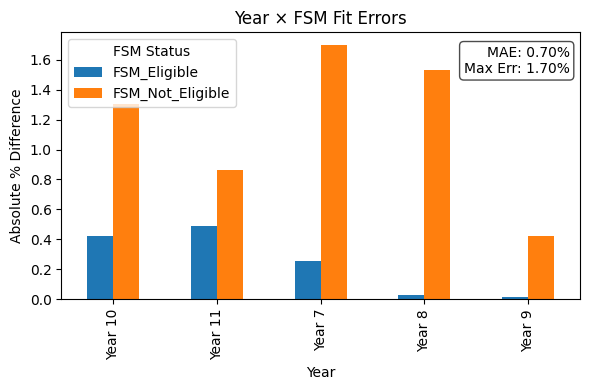

In [61]:
import matplotlib.pyplot as plt

# --- your existing code to build report_yf ---
# (pivot, target_pct, synth_pct, absdiff, report_yf)

# 1) Compute MAE and Max Error
mae = report_yf['AbsDiff_%'].mean()
max_err = report_yf['AbsDiff_%'].max()

print(f"Year×FSM MAE: {mae:.2f}%")
print(f"Year×FSM Max Error: {max_err:.2f}%")

# 2) Plot Year×FSM absolute errors as grouped bars
fig, ax = plt.subplots(figsize=(6,4))
diff_pivot = report_yf.pivot(index='Year', columns='FSM_Status', values='AbsDiff_%')
diff_pivot.plot(kind='bar', ax=ax)

# 3) Annotate MAE and Max Error on the chart
annotation = f"MAE: {mae:.2f}%\nMax Err: {max_err:.2f}%"
ax.text(0.98, 0.95, annotation,
        transform=ax.transAxes,
        ha='right', va='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7),
        fontsize=10)

ax.set_ylabel("Absolute % Difference")
ax.set_title("Year × FSM Fit Errors")
ax.legend(title="FSM Status")
plt.tight_layout()
plt.show()


### SEN

In [62]:
# Real SEN distribution
total_real = sen_counts.sum()
target_pct = (sen_counts / total_real * 100).rename('Target_%')

# Synthetic SEN distribution
synth_counts = (
    student_synth_df['SEN']
      .value_counts()
      .reindex(sens, fill_value=0)
      .rename('Count')
)
total_synth = synth_counts.sum()
synth_pct = (synth_counts / total_synth * 100).rename('Synthetic_%')

# Absolute difference
absdiff = (synth_pct - target_pct).abs().rename('AbsDiff_%')

# Build comparison table
rows = []
for status in sens:
    rows.append({
        'SEN_Status':   status,
        'Target_%':     target_pct.loc[status],
        'Synthetic_%':  synth_pct.loc[status],
        'AbsDiff_%':    absdiff.loc[status]
    })

report_s = pd.DataFrame(rows)

# Display
display(report_s)

,SEN_Status,Target_%,Synthetic_%,AbsDiff_%
0,EHC plans,3.082170,3.730585,0.648415
1,No SEN,83.158145,82.201094,0.957051
2,SEN Support,13.759686,14.068321,0.308636


SEN Distribution MAE: 0.64%
SEN Distribution Max Error: 0.96%


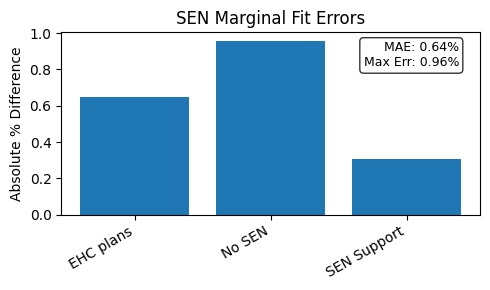

In [63]:
import matplotlib.pyplot as plt

# --- your existing code up to report_s DataFrame ---
# (total_real, target_pct, synth_pct, absdiff, report_s)

# 1) Compute MAE and Max Error
mae = report_s['AbsDiff_%'].mean()
max_err = report_s['AbsDiff_%'].max()

print(f"SEN Distribution MAE: {mae:.2f}%")
print(f"SEN Distribution Max Error: {max_err:.2f}%")

# 2) Plot SEN abs‐diffs as a bar chart
fig, ax = plt.subplots(figsize=(5,3))
ax.bar(report_s['SEN_Status'], report_s['AbsDiff_%'])
ax.set_ylabel("Absolute % Difference")
ax.set_title("SEN Marginal Fit Errors")
plt.xticks(rotation=30, ha='right')

# 3) Annotate MAE and Max Error
annotation = f"MAE: {mae:.2f}%\nMax Err: {max_err:.2f}%"
ax.text(0.95, 0.95, annotation,
        transform=ax.transAxes,
        ha='right', va='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
        fontsize=9)

plt.tight_layout()
plt.show()


### SEN x Gender

In [64]:
# Real SEN×Gender distribution
pivot = pivot_sen_by_gen.copy()
total_real = pivot.values.sum()
target_pct = (pivot / total_real * 100).stack().rename('Target_%')

# Synthetic SEN×Gender distribution
synth_counts = (
    student_synth_df
      .groupby(['Gender','SEN'])
      .size()
      .unstack(fill_value=0)
      .reindex(index=genders, columns=sens, fill_value=0)
)
total_synth = synth_counts.values.sum()
synth_pct = (synth_counts / total_synth * 100).stack().rename('Synthetic_%')

# Absolute difference
absdiff = (synth_pct - target_pct).abs().rename('AbsDiff_%')

# Build the comparison table
rows = []
for gender in genders:
    for sen_status in sens:
        rows.append({
            'Gender':      gender,
            'SEN_Status':  sen_status,
            'Target_%':    target_pct.loc[(gender, sen_status)],
            'Synthetic_%': synth_pct.loc[(gender, sen_status)],
            'AbsDiff_%':   absdiff.loc[(gender, sen_status)]
        })

report_sg = pd.DataFrame(rows)

# Display
display(report_sg)


,Gender,SEN_Status,Target_%,Synthetic_%,AbsDiff_%
0,Female,EHC plans,0.919471,1.025790,0.106319
1,Female,No SEN,43.284194,42.778342,0.505852
2,Female,SEN Support,5.652803,5.559588,0.093215
3,Male,EHC plans,2.162699,2.704795,0.542096
4,Male,No SEN,39.873950,39.422751,0.451199
5,Male,SEN Support,8.106883,8.508734,0.401851


SEN×Gender MAE: 0.35%
SEN×Gender Max Error: 0.54%


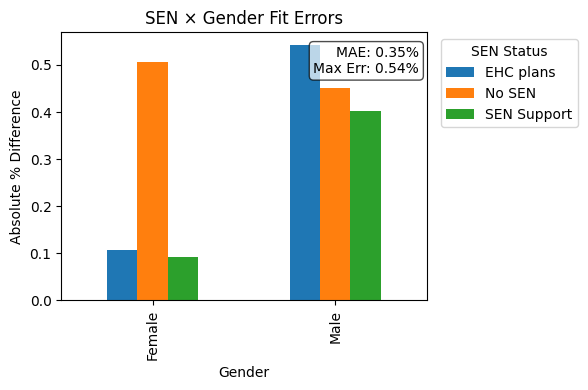

In [65]:
import matplotlib.pyplot as plt

# — your existing code up to report_sg DataFrame —
# (pivot, target_pct, synth_pct, absdiff, report_sg)

# 1) Compute MAE and Max Error
mae = report_sg['AbsDiff_%'].mean()
max_err = report_sg['AbsDiff_%'].max()

print(f"SEN×Gender MAE: {mae:.2f}%")
print(f"SEN×Gender Max Error: {max_err:.2f}%")

# 2) Plot SEN×Gender absolute errors
fig, ax = plt.subplots(figsize=(6,4))
# pivot back to wide form
diff_pivot = report_sg.pivot(index='Gender', columns='SEN_Status', values='AbsDiff_%')
diff_pivot.plot(kind='bar', ax=ax)

# 3) Annotate MAE and Max Error
annotation = f"MAE: {mae:.2f}%\nMax Err: {max_err:.2f}%"
ax.text(0.98, 0.95, annotation,
        transform=ax.transAxes,
        ha='right', va='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7),
        fontsize=10)

ax.set_ylabel("Absolute % Difference")
ax.set_title("SEN × Gender Fit Errors")
ax.legend(title="SEN Status", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


### SEN x Year Group

In [66]:
# Real SEN×Year distribution
pivot = pivot_sen_by_year.copy()
total_real = pivot.values.sum()
target_pct = (pivot / total_real * 100).stack().rename('Target_%')

# Synthetic SEN×Year distribution
years = ['Year 7','Year 8','Year 9','Year 10','Year 11']
sens = ['EHC plans','No SEN','SEN Support']

synth_counts = (
    student_synth_df
      .groupby(['Year','SEN'])
      .size()
      .unstack(fill_value=0)
      .reindex(index=years, columns=sens, fill_value=0)
)
total_synth = synth_counts.values.sum()
synth_pct = (synth_counts / total_synth * 100).stack().rename('Synthetic_%')

# Absolute difference
absdiff = (synth_pct - target_pct).abs().rename('AbsDiff_%')

# Build the comparison table
rows = []
for year in years:
    for sen_status in sens:
        rows.append({
            'Year':        year,
            'SEN_Status':  sen_status,
            'Target_%':    target_pct.loc[(year, sen_status)],
            'Synthetic_%': synth_pct.loc[(year, sen_status)],
            'AbsDiff_%':   absdiff.loc[(year, sen_status)]
        })

report_sy = pd.DataFrame(rows)

# Display
display(report_sy)


,Year,SEN_Status,Target_%,Synthetic_%,AbsDiff_%
0,Year 7,EHC plans,0.667731,0.730633,0.062902
1,Year 7,No SEN,16.659409,14.883631,1.775778
2,Year 7,SEN Support,3.314463,3.072531,0.241932
3,Year 8,EHC plans,0.638699,0.694344,0.055644
4,Year 8,No SEN,16.678763,15.394107,1.284657
5,Year 8,SEN Support,3.280592,2.949146,0.331446
6,Year 9,EHC plans,0.648377,0.742730,0.094353
7,Year 9,No SEN,16.415058,16.840857,0.425800
8,Year 9,SEN Support,2.995113,2.912856,0.082257
9,Year 10,EHC plans,0.687086,0.745149,0.058064


In [67]:
# Compute summary metrics
mae   = report_sy['AbsDiff_%'].mean()
max_e = report_sy['AbsDiff_%'].max()

print(f"SEN×Year MAE:   {mae:.2f}%")
print(f"SEN×Year Max Error: {max_e:.2f}%")


SEN×Year MAE:   0.51%
SEN×Year Max Error: 1.78%


### SEN x FSM

In [68]:
# Real SENxFSM distributions
total_real = pivot_sen_by_fsm.values.sum()
target_pct = (pivot_sen_by_fsm / total_real * 100).stack().rename('Target_%')

# Synthetic SENxFSM distributions
fsms = ['FSM_Eligible','FSM_Not_Eligible']
sens = ['EHC plans','No SEN','SEN Support']

synth_counts = (
    student_synth_df
      .groupby(['FSM','SEN'])
      .size()
      .unstack(fill_value=0)
      .reindex(index=fsms, columns=sens, fill_value=0)
)
total_synth = synth_counts.values.sum()
synth_pct = (synth_counts / total_synth * 100).stack().rename('Synthetic_%')

# Absolute difference
absdiff = (synth_pct - target_pct).abs().rename('AbsDiff_%')

# Build comparison table
rows = []
for f in fsms:
    for s in sens:
        rows.append({
            'FSM_Status':  f,
            'SEN_Status':  s,
            'Target_%':    target_pct.loc[(f,s)],
            'Synthetic_%': synth_pct.loc[(f,s)],
            'AbsDiff_%':   absdiff.loc[(f,s)]
        })

report_sf = pd.DataFrame(rows)

# Display
display(report_sf)

,FSM_Status,SEN_Status,Target_%,Synthetic_%,AbsDiff_%
0,FSM_Eligible,EHC plans,1.370573,2.085450,0.714878
1,FSM_Eligible,No SEN,18.505968,19.272270,0.766302
2,FSM_Eligible,SEN Support,5.259977,6.140224,0.880246
3,FSM_Not_Eligible,EHC plans,1.711597,1.645135,0.066462
4,FSM_Not_Eligible,No SEN,64.652177,62.928824,1.723353
5,FSM_Not_Eligible,SEN Support,8.499709,7.928098,0.571611


In [69]:
# 1) Compute summary metrics
mae   = report_sf['AbsDiff_%'].mean()
max_e = report_sf['AbsDiff_%'].max()

print(f"SEN×FSM MAE:       {mae:.2f}%")
print(f"SEN×FSM Max Error: {max_e:.2f}%")


SEN×FSM MAE:       0.79%
SEN×FSM Max Error: 1.72%


### SEN x Ethnicity

In [70]:
# Real SENxEthnicity distributions
pivot = pivot_sen_by_eth.copy()
pivot.index.name = 'SEN_Status'
pivot.columns.name = 'Ethnicity'

total_real = pivot.values.sum()
target_pct = (pivot / total_real * 100).stack().rename('Target_%')

# Synthetic SENxEthnicity distributions
eths = pivot.columns.tolist()
sens = pivot.index.tolist()

synth_counts = (
    student_synth_df
      .groupby(['SEN','Ethnicity'])
      .size()
      .unstack(fill_value=0)
      .reindex(index=sens, columns=eths, fill_value=0)
)
total_synth = synth_counts.values.sum()
synth_pct = (synth_counts / total_synth * 100).stack().rename('Synthetic_%')

# Absolute difference
absdiff = (synth_pct - target_pct).abs().rename('AbsDiff_%')

# Build comparison table
rows = []
for sen_status in sens:
    for eth in eths:
        rows.append({
            'Ethnicity':   eth,
            'SEN_Status':  sen_status,
            'Target_%':    target_pct.loc[(sen_status, eth)],
            'Synthetic_%': synth_pct.loc[(sen_status, eth)],
            'AbsDiff_%':   absdiff.loc[(sen_status, eth)]
        })

report_se = pd.DataFrame(rows)

# Display
display(report_se)


,Ethnicity,SEN_Status,Target_%,Synthetic_%,AbsDiff_%
0,White - White British,EHC plans,2.849064,3.270915,0.421851
1,White - Any other White background,EHC plans,0.036692,0.065322,0.028629
2,Unclassified,EHC plans,0.056118,0.038709,0.017409
3,Mixed - White and Black Caribbean,EHC plans,0.032376,0.033870,0.001495
4,Mixed - White and Asian,EHC plans,0.025901,0.024193,0.001707
5,Mixed - Any other Mixed background,EHC plans,0.023742,0.045967,0.022225
6,Asian - Indian,EHC plans,0.006475,0.016935,0.010460
7,Black - Black African,EHC plans,0.006475,0.033870,0.027395
8,Asian - Chinese,EHC plans,0.002158,0.009677,0.007519
9,Mixed - White and Black African,EHC plans,0.010792,0.014516,0.003724


In [71]:
# --- after your display(report_se) ---

# 1) Compute summary metrics
mae   = report_se['AbsDiff_%'].mean()
max_e = report_se['AbsDiff_%'].max()

print(f"SEN×Ethnicity MAE:       {mae:.2f}%")
print(f"SEN×Ethnicity Max Error: {max_e:.2f}%")


SEN×Ethnicity MAE:       0.06%
SEN×Ethnicity Max Error: 0.98%


### Suspensions

In [72]:
# Real Suspension distributions
target_pct = (
    overall_susp['percent']
      .rename('Target_%')
      .reindex(['Suspended','Not Suspended'])   # enforce the order
)
# Synthetic Suspension distributions
synth_pct = (
    student_synth_df['Suspended']
      .value_counts(normalize=True)
      .reindex(['Suspended','Not Suspended'], fill_value=0)
      .mul(100)
      .rename('Synthetic_%')
)

# Build comparison table

target_pct = overall_susp['percent'].rename('Target_%')
# Absolute difference
absdiff = (synth_pct - target_pct).abs().rename('AbsDiff_%')

report_sp = pd.DataFrame({
    'Suspension_Status': target_pct.index,
    'Target_%':          target_pct.values,
    'Synthetic_%':       synth_pct.values,
    'AbsDiff_%':         absdiff.values
})

# Display
display(report_sp)


,Suspension_Status,Target_%,Synthetic_%,AbsDiff_%
0,Suspended,4.4,4.787826,0.387826
1,Not Suspended,95.6,95.212174,0.387826


In [73]:
# 1) Compute MAE and Max Error
mae   = report_sp['AbsDiff_%'].mean()
max_e = report_sp['AbsDiff_%'].max()

print(f"Suspension MAE:       {mae:.2f}%")
print(f"Suspension Max Error: {max_e:.2f}%")


Suspension MAE:       0.39%
Suspension Max Error: 0.39%


### Suspensions x Ethnicity

In [74]:
# Real EthnicityxSuspension distribution
real_counts = pivot_es[['Not_Suspended_count','Suspended_count']].copy()
real_counts.columns = ['Not Suspended','Suspended']

total_real = real_counts.values.sum()
target_pct = (real_counts / total_real * 100).stack().rename('Target_%')

# Synthetic Ethnicity×Suspension distribution
student_synth_df['Susp_Status'] = student_synth_df['Suspended'].str.replace('_',' ').replace({
    'Not Suspended':'Not Suspended', 'Suspended':'Suspended'
})

eths = real_counts.index.tolist()
synth_counts = (
    student_synth_df
      .groupby(['Ethnicity','Susp_Status'])
      .size()
      .unstack(fill_value=0)
      .reindex(index=eths, columns=['Not Suspended','Suspended'], fill_value=0)
)

total_synth = synth_counts.values.sum()
synth_pct = (synth_counts / total_synth * 100).stack().rename('Synthetic_%')

# Absolute difference
absdiff = (synth_pct - target_pct).abs().rename('AbsDiff_%')

# Build comparison table
rows = []
for eth in eths:
    for status in ['Not Suspended','Suspended']:
        rows.append({
            'Ethnicity':       eth,
            'Susp_Status':     status,
            'Target_%':        target_pct.loc[(eth,status)],
            'Synthetic_%':     synth_pct.loc[(eth,status)],
            'AbsDiff_%':       absdiff.loc[(eth,status)]
        })
report_es = pd.DataFrame(rows)

# Display
display(report_es)


,Ethnicity,Susp_Status,Target_%,Synthetic_%,AbsDiff_%
0,White - White British,Not Suspended,85.314368,84.274447,1.039921
1,White - White British,Suspended,3.993007,4.362026,0.369020
2,White - Any other White background,Not Suspended,2.669919,2.656409,0.013510
3,White - Any other White background,Suspended,0.090652,0.055644,0.035008
4,Unclassified,Not Suspended,1.027390,1.047564,0.020174
5,Unclassified,Suspended,0.092810,0.120966,0.028155
6,Mixed - White and Black Caribbean,Not Suspended,0.943213,1.069338,0.126125
7,Mixed - White and Black Caribbean,Suspended,0.084177,0.043548,0.040629
8,Mixed - White and Asian,Not Suspended,0.979905,0.970146,0.009760
9,Mixed - White and Asian,Suspended,0.023742,0.019355,0.004388


In [75]:
# 1) Compute MAE and Max Error for Ethnicity×Suspension
mae_es   = report_es['AbsDiff_%'].mean()
max_es   = report_es['AbsDiff_%'].max()

print(f"Ethnicity×Suspension MAE:       {mae_es:.2f}%")
print(f"Ethnicity×Suspension Max Error: {max_es:.2f}%")


Ethnicity×Suspension MAE:       0.07%
Ethnicity×Suspension Max Error: 1.04%


### Suspensions x Gender

In [76]:
pivot = pivot_susp_gen_counts

# Real Suspension × Gender distributions
real_counts = pivot.rename(columns={
    'Not_Suspended_count': 'Not Suspended',
    'Suspended_count':     'Suspended'
})

total_real = real_counts.values.sum()
target_pct = (real_counts / total_real * 100).stack().rename('Target_%')

# Synthetic Gender × Suspension distributions
student_synth_df['Suspended'] =student_synth_df['Suspended']
synth_counts = (
    student_synth_df
      .groupby(['Gender', 'Suspended'])
      .size()
      .unstack(fill_value=0)
      .reindex(index=genders, columns=['Not Suspended','Suspended'], fill_value=0)
)

total_synth = synth_counts.values.sum()
synth_pct = (synth_counts / total_synth * 100).stack().rename('Synthetic_%')

# Absolute difference
absdiff = (synth_pct - target_pct).abs().rename('AbsDiff_%')

# Build comparison table
rows = []
for gender in genders:
    for status in ['Not Suspended','Suspended']:
        rows.append({
            'Gender':      gender,
            'Susp_Status': status,
            'Target_%':    target_pct.loc[(gender, status)],
            'Synthetic_%': synth_pct.loc[(gender, status)],
            'AbsDiff_%':   absdiff.loc[(gender, status)]
        })
report_sg = pd.DataFrame(rows)

# Display
display(report_sg)


,Gender,Susp_Status,Target_%,Synthetic_%,AbsDiff_%
0,Female,Not Suspended,48.151730,47.694392,0.457338
1,Female,Suspended,1.717172,1.669328,0.047844
2,Male,Not Suspended,47.457554,47.517782,0.060228
3,Male,Suspended,2.673544,3.118498,0.444954


Gender×Suspension MAE:       0.25%
Gender×Suspension Max Error: 0.46%


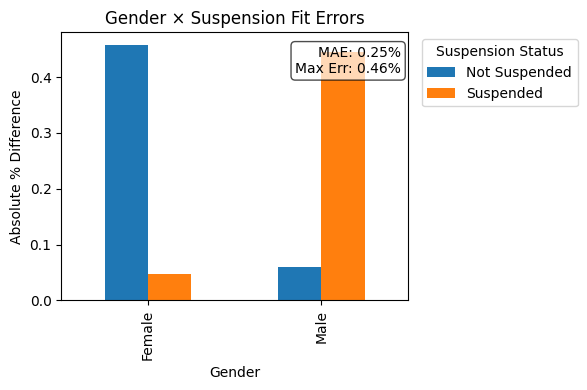

In [77]:
import matplotlib.pyplot as plt

# --- after your display(report_sg) ---

# 1) Compute MAE and Max Error
mae_sg   = report_sg['AbsDiff_%'].mean()
max_sg   = report_sg['AbsDiff_%'].max()

print(f"Gender×Suspension MAE:       {mae_sg:.2f}%")
print(f"Gender×Suspension Max Error: {max_sg:.2f}%")

# 2) Pivot back for plotting
diff_sg = report_sg.pivot(index='Gender', columns='Susp_Status', values='AbsDiff_%')

# 3) Plot grouped bars
fig, ax = plt.subplots(figsize=(6,4))
diff_sg.plot(kind='bar', ax=ax)

# 4) Annotate MAE and Max Error on the chart
annotation = f"MAE: {mae_sg:.2f}%\nMax Err: {max_sg:.2f}%"
ax.text(0.98, 0.95, annotation,
        transform=ax.transAxes,
        ha='right', va='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7),
        fontsize=10)

ax.set_ylabel("Absolute % Difference")
ax.set_title("Gender × Suspension Fit Errors")
ax.legend(title="Suspension Status", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()


### Suspensions x Year Group

In [78]:
# Real SuspensionxYear distribution
pivot = susp_yrgp_pivot_counts.rename(columns={
    'Not_Suspended_count': 'Not Suspended',
    'Suspended_count':     'Suspended'
})
pivot.index.name = 'Year'
total_real = pivot.values.sum()

years = ['Year 7','Year 8','Year 9','Year 10','Year 11']
statuses = ['Not Suspended','Suspended']

synth_counts = (
    student_synth_df
      .groupby(['Year','Susp_Status'])
      .size()
      .unstack(fill_value=0)
      .reindex(index=years, columns=statuses, fill_value=0)
)

total_synth = synth_counts.values.sum()

# Build comparison table
rows = []
for year in years:
    for status in statuses:
        real_ct  = pivot.loc[year, status]
        syn_ct   = synth_counts.loc[year, status]
        tgt_pct  = real_ct  / total_real  * 100
        syn_pct  = syn_ct   / total_synth * 100
        absdiff  = abs(syn_pct - tgt_pct)

        rows.append({
            'Year':         year,
            'Susp_Status':  status,
            'Target_%':     round(tgt_pct, 2),
            'Synthetic_%':  round(syn_pct, 2),
            'AbsDiff_%':    round(absdiff, 2)
        })

report_ys = pd.DataFrame(rows)

# Display
display(report_ys)

,Year,Susp_Status,Target_%,Synthetic_%,AbsDiff_%
0,Year 7,Not Suspended,20.11,17.41,2.69
1,Year 7,Suspended,0.52,1.27,0.75
2,Year 8,Not Suspended,19.75,17.92,1.83
3,Year 8,Suspended,0.83,1.12,0.28
4,Year 9,Not Suspended,18.89,19.97,1.08
5,Year 9,Suspended,1.14,0.52,0.61
6,Year 10,Not Suspended,17.95,20.10,2.15
7,Year 10,Suspended,1.20,0.77,0.43
8,Year 11,Not Suspended,18.46,19.81,1.34
9,Year 11,Suspended,1.15,1.10,0.04


Year×Suspension MAE:       1.12%
Year×Suspension Max Error: 2.69%


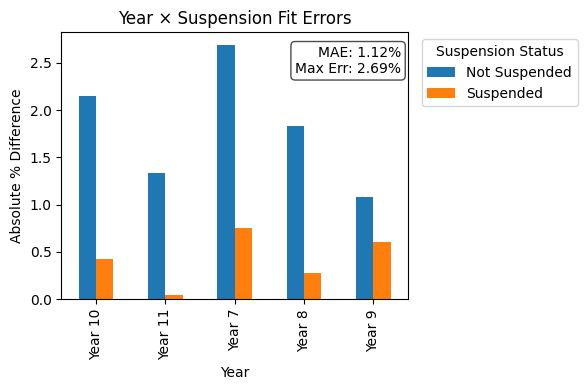

In [79]:
import matplotlib.pyplot as plt

# 1) Compute MAE and Max Error
mae_ys = report_ys['AbsDiff_%'].mean()
max_ys = report_ys['AbsDiff_%'].max()

print(f"Year×Suspension MAE:       {mae_ys:.2f}%")
print(f"Year×Suspension Max Error: {max_ys:.2f}%")

# 2) Pivot for plotting
diff_ys = report_ys.pivot(index='Year', columns='Susp_Status', values='AbsDiff_%')

# 3) Plot grouped bars
fig, ax = plt.subplots(figsize=(6,4))
diff_ys.plot(kind='bar', ax=ax)

# 4) Annotate MAE and Max Error
annotation = f"MAE: {mae_ys:.2f}%\nMax Err: {max_ys:.2f}%"
ax.text(0.98, 0.95, annotation,
        transform=ax.transAxes,
        ha='right', va='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7),
        fontsize=10)

ax.set_ylabel("Absolute % Difference")
ax.set_title("Year × Suspension Fit Errors")
ax.legend(title="Suspension Status", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()


### Suspensions x FSM

In [80]:
# Real Suspension×FSM distribution
pivot = pivot_susp_FSM_counts.rename(columns={
    'Not_Suspended_count': 'Not Suspended',
    'Suspended_count':     'Suspended'
})
pivot.index.name = 'FSM_Status'
total_real = pivot.values.sum()

fsms = ['FSM_Eligible','FSM_Not_Eligible']

synth_counts = (
    student_synth_df
      .groupby(['FSM','Susp_Status'])
      .size()
      .unstack(fill_value=0)
      .reindex(index=fsms, columns=['Not Suspended','Suspended'], fill_value=0)
)

total_synth = synth_counts.values.sum()

# Build comparison table
rows = []
for f in fsms:
    for status in ['Not Suspended','Suspended']:
        real_ct  = pivot.loc[f, status]
        syn_ct   = synth_counts.loc[f, status]
        tgt_pct  = real_ct  / total_real  * 100
        syn_pct  = syn_ct   / total_synth * 100
        absdiff  = abs(syn_pct - tgt_pct)

        rows.append({
            'FSM_Status':   f,
            'Susp_Status':  status,
            'Target_%':     round(tgt_pct, 2),
            'Synthetic_%':  round(syn_pct, 2),
            'AbsDiff_%':    round(absdiff, 2)
        })

report_fsm_sp = pd.DataFrame(rows)

# Display
display(report_fsm_sp)


,FSM_Status,Susp_Status,Target_%,Synthetic_%,AbsDiff_%
0,FSM_Eligible,Not Suspended,22.54,24.35,1.81
1,FSM_Eligible,Suspended,2.48,3.15,0.67
2,FSM_Not_Eligible,Not Suspended,73.07,70.87,2.20
3,FSM_Not_Eligible,Suspended,1.91,1.64,0.27


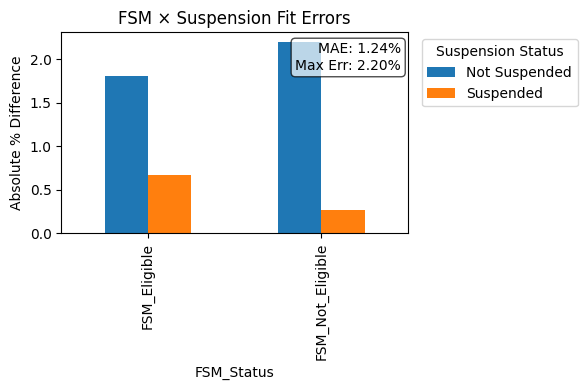

In [81]:
mae = report_fsm_sp['AbsDiff_%'].mean()
max_err = report_fsm_sp['AbsDiff_%'].max()

diff_pivot = report_fsm_sp.pivot(index='FSM_Status', columns='Susp_Status', values='AbsDiff_%')

# Plot grouped bars
fig, ax = plt.subplots(figsize=(6,4))
diff_pivot.plot(kind='bar', ax=ax)

annotation = f"MAE: {mae:.2f}%\nMax Err: {max_err:.2f}%"
ax.text(0.98, 0.95, annotation,
        transform=ax.transAxes,
        ha='right', va='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7),
        fontsize=10)

ax.set_ylabel("Absolute % Difference")
ax.set_title("FSM × Suspension Fit Errors")
ax.legend(title="Suspension Status", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()


### Suspensions x SEN

In [82]:
# Real Suspension×SEN distributions
pivot = pivot_susp_SEN_counts.rename(columns={
    'Not_Suspended_count': 'Not Suspended',
    'Suspended_count':     'Suspended'
})
pivot.index.name = 'SEN_Status'
total_real = pivot.values.sum()

sens = ['EHC plans','No SEN','SEN Support']

synth_counts = (
    student_synth_df
      .groupby(['SEN','Susp_Status'])
      .size()
      .unstack(fill_value=0)
      .reindex(index=sens, columns=['Not Suspended','Suspended'], fill_value=0)
)

total_synth = synth_counts.values.sum()

# Build comparison table
rows = []
for s in sens:
    for status in ['Not Suspended','Suspended']:
        real_ct  = pivot.loc[s, status]
        syn_ct   = synth_counts.loc[s, status]
        tgt_pct  = real_ct  / total_real  * 100
        syn_pct  = syn_ct   / total_synth * 100
        absdiff  = abs(syn_pct - tgt_pct)

        rows.append({
            'SEN_Status':    s,
            'Susp_Status':   status,
            'Target_%':      round(tgt_pct, 2),
            'Synthetic_%':   round(syn_pct, 2),
            'AbsDiff_%':     round(absdiff, 2)
        })

report_ss = pd.DataFrame(rows)

# Display
display(report_ss)


,SEN_Status,Susp_Status,Target_%,Synthetic_%,AbsDiff_%
0,EHC plans,Not Suspended,2.39,3.18,0.78
1,EHC plans,Suspended,0.34,0.55,0.21
2,No SEN,Not Suspended,80.75,79.61,1.14
3,No SEN,Suspended,2.56,2.59,0.03
4,SEN Support,Not Suspended,12.47,12.42,0.04
5,SEN Support,Suspended,1.49,1.65,0.16


SEN × Suspension MAE: 0.39%
SEN × Suspension Max Error: 1.14%


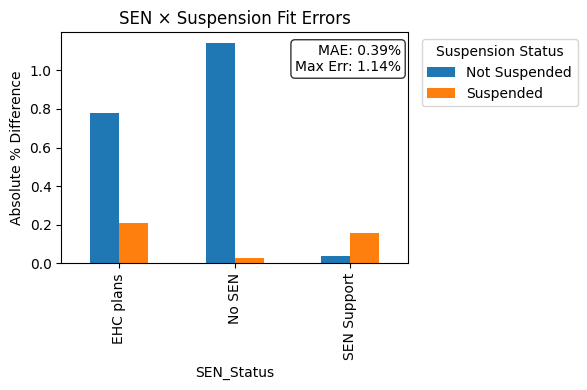

In [83]:
# Compute metrics
mae_ss = report_ss['AbsDiff_%'].mean()
max_ss = report_ss['AbsDiff_%'].max()

print(f"SEN × Suspension MAE: {mae_ss:.2f}%")
print(f"SEN × Suspension Max Error: {max_ss:.2f}%")

# Pivot and plot
diff_ss = report_ss.pivot(index='SEN_Status', columns='Susp_Status', values='AbsDiff_%')
fig, ax = plt.subplots(figsize=(6, 4))
diff_ss.plot(kind='bar', ax=ax)

# Annotate
annotation = f"MAE: {mae_ss:.2f}%\nMax Err: {max_ss:.2f}%"
ax.text(0.98, 0.95, annotation,
        transform=ax.transAxes,
        ha='right', va='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
        fontsize=10)

ax.set_ylabel("Absolute % Difference")
ax.set_title("SEN × Suspension Fit Errors")
ax.legend(title="Suspension Status", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

### CIN

In [84]:
p_cin = 0.0333
levels = ['No CIN', 'CIN']
target_pct = [100*(1-p_cin), 100*p_cin]

# Synthetic CIN distribution
synth_dist = (
    student_synth_df['CIN']
      .value_counts(normalize=True)
      .reindex(levels, fill_value=0)
      .mul(100)
)

# Build comparison table
report_cin = pd.DataFrame({
    'CIN':         levels,
    'Target_%':    np.round(target_pct, 2),
    'Synthetic_%': synth_dist.values.round(2),
})
report_cin['AbsDiff_%'] = (report_cin['Synthetic_%'] - report_cin['Target_%']).abs().round(2)

# Display
display(report_cin)

,CIN,Target_%,Synthetic_%,AbsDiff_%
0,No CIN,96.67,96.8,0.13
1,CIN,3.33,3.2,0.13


In [85]:
mae_cin = report_cin['AbsDiff_%'].mean()
max_cin = report_cin['AbsDiff_%'].max()

print(f"CIN MAE:     {mae_cin:.2f}%")
print(f"CIN Max Err: {max_cin:.2f}%")


CIN MAE:     0.13%
CIN Max Err: 0.13%


### CIN x Gender

In [86]:
real_joint = P_gender_cin

# Synthetic CIN×Gender probabilities
synth_joint = (
    student_synth_df
      .groupby(['Gender','CIN'])
      .size()
      .unstack(fill_value=0)
      .div(len(student_synth_df))
)

# Build comparison table
rows = []
for gender in real_joint.index:
    for cin in real_joint.columns:
        tgt = real_joint.loc[gender, cin] * 100
        syn = synth_joint.loc[gender, cin] * 100
        rows.append({
            'Gender':     gender,
            'CIN':        cin,
            'Target_%':   round(tgt, 2),
            'Synthetic_%':round(syn, 2),
            'AbsDiff_%':  round(abs(syn - tgt), 2)
        })

report_cin_gender = pd.DataFrame(rows)

# Overall MAE and Max Error
mae = report_cin_gender['AbsDiff_%'].mean()
max_err = report_cin_gender['AbsDiff_%'].max()

print(f"CIN×Gender MAE:     {mae:.2f}%")
print(f"CIN×Gender MaxErr: {max_err:.2f}%\n")

# Display
display(report_cin_gender)


CIN×Gender MAE:     0.28%
CIN×Gender MaxErr: 0.44%



,Gender,CIN,Target_%,Synthetic_%,AbsDiff_%
0,Female,No CIN,47.68,48.12,0.44
1,Female,CIN,1.48,1.24,0.24
2,Male,No CIN,48.99,48.68,0.31
3,Male,CIN,1.85,1.96,0.11


### CIN x Ethnicity

In [87]:
real_joint = P_eth_cin.copy()

# Convert to percentages
real_pct = real_joint * 100

# Synthetic CIN×Eth distribution
synth_joint = (
    student_synth_df
      .groupby(['Ethnicity','CIN'])
      .size()
      .unstack(fill_value=0)
      .div(len(student_synth_df))
      .mul(100)
)

# Ensure same index/columns
synth_pct = synth_joint.reindex(
    index=real_pct.index,
    columns=real_pct.columns,
    fill_value=0
)

# Build comparison table
rows = []
for eth in real_pct.index:
    for cin in real_pct.columns:
        tgt = real_pct.loc[eth, cin]
        syn = synth_pct.loc[eth, cin]
        rows.append({
            'Ethnicity':    eth,
            'CIN':          cin,
            'Target_%':     round(tgt, 2),
            'Synthetic_%':  round(syn, 2),
            'AbsDiff_%':    round(abs(syn - tgt), 2),
        })

report_eth_cin = pd.DataFrame(rows)

# Compute overall MAE and Max Error
mae = report_eth_cin['AbsDiff_%'].mean()
max_err = report_eth_cin['AbsDiff_%'].max()

print(f"CIN×Ethnicity MAE:     {mae:.2f}%")
print(f"CIN×Ethnicity MaxErr: {max_err:.2f}%\n")

# Display
display(report_eth_cin)


CIN×Ethnicity MAE:     0.03%
CIN×Ethnicity MaxErr: 0.10%



,Ethnicity,CIN,Target_%,Synthetic_%,AbsDiff_%
0,White - White British,No CIN,86.33,86.43,0.09
1,White - White British,CIN,2.10,2.21,0.10
2,White - Any other White background,No CIN,2.67,2.61,0.06
3,White - Any other White background,CIN,0.16,0.10,0.06
4,Unclassified,No CIN,1.08,1.17,0.09
5,Unclassified,CIN,0.00,0.00,0.00
6,Mixed - White and Black Caribbean,No CIN,0.99,1.09,0.09
7,Mixed - White and Black Caribbean,CIN,0.10,0.03,0.07
8,Mixed - White and Asian,No CIN,0.97,0.95,0.02
9,Mixed - White and Asian,CIN,0.05,0.04,0.02


### CIN x FSM

In [88]:
real_joint_pct = P_fsm_cin * 100

# Synthetic CIN×FSM
synth_joint_pct = (
    student_synth_df
      .groupby(['FSM','CIN'])
      .size()
      .unstack(fill_value=0)
      .div(len(student_synth_df))
      .mul(100)
)

synth_joint_pct = synth_joint_pct.reindex(
    index=real_joint_pct.index,
    columns=real_joint_pct.columns,
    fill_value=0
)

# Build comparison table
rows = []
for fsm in real_joint_pct.index:
    for cin in real_joint_pct.columns:
        tgt = real_joint_pct.loc[fsm, cin]
        syn = synth_joint_pct.loc[fsm, cin]
        rows.append({
            'FSM':         fsm,
            'CIN':         cin,
            'Target_%':    round(tgt, 2),
            'Synthetic_%': round(syn, 2),
            'AbsDiff_%':   round(abs(syn - tgt), 2),
        })
report_cin_fsm = pd.DataFrame(rows)

# MAE and Max Error
mae = report_cin_fsm['AbsDiff_%'].mean()
max_err = report_cin_fsm['AbsDiff_%'].max()

print(f"CIN×FSM MAE:     {mae:.2f}%")
print(f"CIN×FSM MaxErr:  {max_err:.2f}%\n")

# Display
display(report_cin_fsm)


CIN×FSM MAE:     0.53%
CIN×FSM MaxErr:  1.00%



,FSM,CIN,Target_%,Synthetic_%,AbsDiff_%
0,FSM_Eligible,No CIN,25.95,25.08,0.87
1,FSM_Eligible,CIN,2.35,2.41,0.06
2,FSM_Not_Eligible,No CIN,70.72,71.72,1.00
3,FSM_Not_Eligible,CIN,0.98,0.79,0.19


### CIN x SEN

In [89]:
real_joint_pct = P_sen_cin * 100

# Synthetic SEN×CIN
synth_joint_pct = (
    student_synth_df
      .groupby(['SEN','CIN'])
      .size()
      .unstack(fill_value=0)
      .div(len(student_synth_df))
      .mul(100)
)

synth_joint_pct = synth_joint_pct.reindex(
    index=real_joint_pct.index,
    columns=real_joint_pct.columns,
    fill_value=0
)

# Build comparison table
rows = []
for sen in real_joint_pct.index:
    for cin in real_joint_pct.columns:
        tgt = real_joint_pct.loc[sen, cin]
        syn = synth_joint_pct.loc[sen, cin]
        rows.append({
            'SEN':         sen,
            'CIN':         cin,
            'Target_%':    round(tgt, 2),
            'Synthetic_%': round(syn, 2),
            'AbsDiff_%':   round(abs(syn - tgt), 2),
        })
report_sen_cin = pd.DataFrame(rows)

# MAE and Max Error
mae = report_sen_cin['AbsDiff_%'].mean()
max_err = report_sen_cin['AbsDiff_%'].max()

print(f"SEN×CIN MAE:     {mae:.2f}%")
print(f"SEN×CIN MaxErr:  {max_err:.2f}%\n")

# Display
display(report_sen_cin)


SEN×CIN MAE:     0.08%
SEN×CIN MaxErr:  0.23%



,SEN,CIN,Target_%,Synthetic_%,AbsDiff_%
0,EHC plans,No CIN,2.98,2.92,0.06
1,EHC plans,CIN,0.84,0.81,0.03
2,No SEN,No CIN,80.39,80.61,0.23
3,No SEN,CIN,1.66,1.59,0.08
4,SEN Support,No CIN,13.30,13.26,0.04
5,SEN Support,CIN,0.83,0.81,0.02


### CIN x Suspensions

In [90]:
real_joint_pct = P_susp_cin * 100

# Synthetic Suspension × CIN
synth_joint_pct = (
    student_synth_df
      .groupby(['Susp_Status','CIN'])
      .size()
      .unstack(fill_value=0)
      .div(len(student_synth_df))
      .mul(100)
)

synth_joint_pct = synth_joint_pct.reindex(
    index=real_joint_pct.index,
    columns=real_joint_pct.columns,
    fill_value=0
)

# Build comparison table
rows = []
for susp in real_joint_pct.index:
    for cin in real_joint_pct.columns:
        tgt = real_joint_pct.loc[susp, cin]
        syn = synth_joint_pct.loc[susp, cin]
        rows.append({
            'Susp_Status':  susp,
            'CIN':          cin,
            'Target_%':     round(tgt, 2),
            'Synthetic_%':  round(syn, 2),
            'AbsDiff_%':    round(abs(syn - tgt), 2),
        })
report_susp_cin = pd.DataFrame(rows)

# MAE and Max Error
mae = report_susp_cin['AbsDiff_%'].mean()
max_err = report_susp_cin['AbsDiff_%'].max()

print(f"Suspension×CIN MAE:     {mae:.2f}%")
print(f"Suspension×CIN MaxErr:  {max_err:.2f}%\n")

# Display
display(report_susp_cin)


Suspension×CIN MAE:     0.08%
Suspension×CIN MaxErr:  0.15%



,Susp_Status,CIN,Target_%,Synthetic_%,AbsDiff_%
0,Not Suspended,No CIN,92.43,92.47,0.05
1,Not Suspended,CIN,2.89,2.74,0.15
2,Suspended,No CIN,4.24,4.33,0.08
3,Suspended,CIN,0.44,0.46,0.02


### Overall

In [91]:
tables = {
    'YearxGender': report_yg,
    'Ethnicity': report_eth,
    'FSM': report_fsm,
    'FSMxYear':     report_yf,
    "FSMxEthnicity": report_ef,
    'SEN': report_s,
    'SENxGender':report_sg,
    'SENxYear': report_sy,
    'SENxFSM':      report_sf,
    'SENxEthnicity': report_se,
    'Suspension': report_sp,
    'SuspensionxGender': report_sg,
    'SuspensionxEthnicity': report_es,
    'SuspensionxYear':    report_ys,
    'SuspensionxFSM':     report_fsm_sp,
    'SuspensionxSEN':     report_ss,
    'CIN': report_cin,
    'CIN x Gender': report_cin_gender,
    'CIN x Ethnicity': report_eth_cin,
    'CIN x FSM': report_cin_fsm,
    'CIN x SEN': report_sen_cin,
    'CIN x Suspensions': report_susp_cin
}

# All differences in one df
df_list = []
for name, df in tables.items():
    tmp = df[['AbsDiff_%']].copy()
    tmp['Table'] = name
    df_list.append(tmp)

all_errors = pd.concat(df_list, ignore_index=True)

# Overall metrics
overall_mae    = all_errors['AbsDiff_%'].mean()
overall_max    = all_errors['AbsDiff_%'].max()
overall_rmse   = np.sqrt((all_errors['AbsDiff_%']**2).mean())

print(f"Overall MAE:   {overall_mae:.2f}%")
print(f"Overall Max:   {overall_max:.2f}%")
print(f"Overall RMSE:  {overall_rmse:.2f}%")

# Per table summary
per_table = all_errors.groupby('Table')['AbsDiff_%'] \
                      .agg(MAE='mean', Max='max', RMSE=lambda x: np.sqrt((x**2).mean())) \
                      .round(2)

print(per_table)


Overall MAE:   0.26%
Overall Max:   3.68%
Overall RMSE:  0.56%
                       MAE   Max  RMSE
Table                                 
CIN                   0.13  0.13  0.13
CIN x Ethnicity       0.03  0.10  0.04
CIN x FSM             0.53  1.00  0.67
CIN x Gender          0.28  0.44  0.30
CIN x SEN             0.08  0.23  0.10
CIN x Suspensions     0.08  0.15  0.09
Ethnicity             0.09  0.67  0.17
FSM                   0.65  0.65  0.65
FSMxEthnicity         0.27  3.68  0.79
FSMxYear              0.70  1.70  0.91
SEN                   0.64  0.96  0.69
SENxEthnicity         0.06  0.98  0.15
SENxFSM               0.79  1.72  0.93
SENxGender            0.25  0.46  0.32
SENxYear              0.51  1.78  0.80
Suspension            0.39  0.39  0.39
SuspensionxEthnicity  0.07  1.04  0.19
SuspensionxFSM        1.24  2.20  1.47
SuspensionxGender     0.25  0.46  0.32
SuspensionxSEN        0.39  1.14  0.57
SuspensionxYear       1.12  2.69  1.39
YearxGender           0.70  1.11  0.76


# Attendance

## Distributions

### Overall Absense Rate

In [334]:
# Overall absence data
df_over = pd.read_csv(
    '/content/drive/MyDrive/pupildata/absense_secondary_derbyshire.csv'
).rename(columns={'sess_overall_percent':'Absence_pct'})

overall_pct = df_over.loc[
    df_over['education_phase']=='State-funded secondary',
    'Absence_pct'
].iloc[0]

# Display
print("Overall absence pct:", overall_pct)

Overall absence pct: 9.17123


### Absense by SEN

In [335]:
# Load data
df_abs_sen = pd.read_csv('/content/drive/MyDrive/pupildata/absense_sen_secondary_derbyshire.csv')

# Rename columns
df_abs_sen = df_abs_sen.rename(columns={
    'sess_overall_percent': 'Attendance',
    'characteristic':       'SEN'
})

# Strip leading SEN
df_abs_sen['SEN'] = df_abs_sen['SEN'] \
    .str.replace(r'^SEN\s*[-–]\s*', '', regex=True)

# Pivot table
att_sen = df_abs_sen.pivot_table(
    index='SEN',
    values='Attendance',
    aggfunc='mean'
)
att_sen.name = 'Attendance'

print("Average attendance by SEN status (cleaned):")
att_sen

Average attendance by SEN status (cleaned):


,Attendance
SEN,
EHC plans,15.01680
No SEN,6.08592
SEN Support,10.37620


### Absense by Year Group

In [336]:
# Load dataset
df_abs_yr = pd.read_csv('/content/drive/MyDrive/pupildata/absense_yrgp_secondary_derbyshire.csv')

# Rename and filter
df_abs_yr = (
    df_abs_yr
      .query("education_phase == 'Total'")
      .rename(columns={
          'characteristic':       'Year',
          'sess_overall_percent': 'Attendance'
      })
)

# Strip leading NC
df_abs_yr['Year'] = df_abs_yr['Year'].str.replace(
    r'^NC\s+', '', regex=True
)

# Pivot table
att_year = df_abs_yr.pivot_table(
    index='Year',
    values='Attendance',
    aggfunc='mean'
)
att_year.name = 'Attendance'

print("Average attendance by Year (cleaned):")
att_year


Average attendance by Year (cleaned):


,Attendance
Year,
Year 10,10.61938
Year 11,10.62465
Year 7,6.90552
Year 8,8.49124
Year 9,9.83569


### Absense by Ethnicity

In [337]:
# Load data
df_eth = pd.read_csv('/content/drive/MyDrive/pupildata/absense_ethnicity_secondary_derbyshire.csv')
df_eth.head(5)

,time_period,time_identifier,geographic_level,country_code,country_name,region_code,region_name,old_la_code,new_la_code,la_name,education_phase,characteristic,sess_overall_percent
0,202324,Academic year,Local authority,E92000001,England,E12000004,East Midlands,830,E10000007,Derbyshire,Total,Ethnicity Minor Any other Asian background,5.39652
1,202324,Academic year,Local authority,E92000001,England,E12000004,East Midlands,830,E10000007,Derbyshire,Total,Ethnicity Minor Any other black background,5.90740
2,202324,Academic year,Local authority,E92000001,England,E12000004,East Midlands,830,E10000007,Derbyshire,Total,Ethnicity Minor Any Other Ethnic Group,6.70943
3,202324,Academic year,Local authority,E92000001,England,E12000004,East Midlands,830,E10000007,Derbyshire,Total,Ethnicity Minor Any other Mixed background,7.31829
4,202324,Academic year,Local authority,E92000001,England,E12000004,East Midlands,830,E10000007,Derbyshire,Total,Ethnicity Minor Any other white background,6.56788


In [338]:
# Rename and clean the Ethnicity column
df_eth = df_eth.rename(columns={
    'characteristic': 'Ethnicity',
    'sess_overall_percent': 'Attendance'
})

# Remove the leading “Ethnicity Minor ” prefix
df_eth['Ethnicity'] = df_eth['Ethnicity'].str.replace(
    r'^Ethnicity Minor\s*', '', regex=True
).str.strip()

df_eth['Ethnicity'] = df_eth['Ethnicity'] \
                        .map(raw_to_master)

# Mean attendance by the cleaned Ethnicity
att_eth = (
    df_eth
      .groupby('Ethnicity')['Attendance']
      .mean()
      .reindex(ethnicities_master)
)

# Display
att_eth.name = 'Attendance'
print("Average attendance by Ethnicity (master order):")
att_eth

Average attendance by Ethnicity (master order):


,Attendance
Ethnicity,
White - White British,7.11342
White - Any other White background,6.56788
Unclassified,10.38931
Mixed - White and Black Caribbean,9.11538
Mixed - White and Asian,6.36043
Mixed - Any other Mixed background,7.31829
Asian - Indian,5.15093
Black - Black African,3.31392
Asian - Chinese,3.15644


### Absense by FSM

In [339]:
# Load the FSM absence dataset
df_fsm = pd.read_csv('/content/drive/MyDrive/pupildata/absense_fsm_secondary_derbyshire.csv')
df_fsm.head()

,time_period,time_identifier,geographic_level,country_code,country_name,region_code,region_name,old_la_code,new_la_code,la_name,education_phase,characteristic,sess_overall_percent
0,202324,Academic year,Local authority,E92000001,England,E12000004,East Midlands,830,E10000007,Derbyshire,Total,FSM eligible,10.85446
1,202324,Academic year,Local authority,E92000001,England,E12000004,East Midlands,830,E10000007,Derbyshire,Total,FSM Not eligible,5.58078


In [340]:
# Rename columns
df_fsm = df_fsm.rename(columns={
    'characteristic':       'FSM',
    'sess_overall_percent': 'Attendance'
})

# Map raw FSM labels to master labels
fsm_map = {
    'FSM eligible': 'FSM_Eligible',
    'FSM Not eligible': 'FSM_Not_Eligible'
}
df_fsm['FSM'] = df_fsm['FSM'].map(fsm_map).fillna('FSM_Not_Eligible')

# Mean attendance by FSM_status
att_fsm = df_fsm.groupby('FSM')['Attendance'].mean()
att_fsm = att_fsm.reindex(['FSM_Eligible','FSM_Not_Eligible'])
att_fsm.name = 'Attendance'

# Display
print("Average attendance by FSM status:")
att_fsm

Average attendance by FSM status:


,Attendance
FSM,
FSM_Eligible,10.85446
FSM_Not_Eligible,5.58078


### Absense by CIN

In [341]:
# CIN absence data
df_cin_abs = pd.read_csv(
    '/content/drive/MyDrive/pupildata/CIN_absense_secondary_nationally.csv'
).rename(columns={
    'pt_overall':'Attendance',
    'social_care_group':'CIN_status'
})

cin_pct = df_cin_abs.loc[
    df_cin_abs['CIN_status']=='CINO at 31 March',
    'Attendance'
].iloc[0]

print("CIN absence pct:", cin_pct)

# Weight the non CIN absense
A_over = overall_pct / 100.0
A_cin = cin_pct     / 100.0

A_non = (A_over - p_cin*A_cin) / (1 - p_cin)
noncin_pct = A_non * 100.0

print("Non‐CIN absence pct:", noncin_pct)

# Build absense pivot
att_cin = pd.Series(
    [noncin_pct, cin_pct],
    index=['No CIN','CIN'],
    name='Attendance',
    dtype=float
)

# Display
print("\nAbsence by CIN status:")
print(att_cin.round(1))

CIN absence pct: 25.9
Non‐CIN absence pct: 8.594972587152167

Absence by CIN status:
No CIN     8.6
CIN       25.9
Name: Attendance, dtype: float64


## Generation

In [342]:
from sklearn.linear_model import LinearRegression

# Marginal means
dfs = []
for name, series in [
    ('Year',      att_year),
    ('Ethnicity', att_eth),
    ('FSM',       att_fsm),
    ('SEN',       att_sen),
    ('CIN',       att_cin),
]:
    tmp = series.reset_index().rename(
        columns={'index': name, 'Attendance': 'Attendance'}
    )
    dfs.append(tmp)
df_margins = pd.concat(dfs, ignore_index=True)

# Fit no intercept additive model
X = pd.get_dummies(
    df_margins[['Year','Ethnicity','FSM','SEN','CIN']],
    drop_first=False
)
y = df_margins['Attendance'].values
mu = y.mean()
y_centered = y - mu

lr = LinearRegression(fit_intercept=False).fit(X, y_centered)
beta = pd.Series(lr.coef_, index=X.columns)

# Residual pool
resid_pool = y_centered - lr.predict(X)
sigma = resid_pool.std(ddof=0)

# Encode synthetic profiles
X_synth = (
    pd.get_dummies(
        student_synth_df[['Year','Ethnicity','FSM','SEN','CIN']],
        drop_first=False
    )
    .reindex(columns=X.columns, fill_value=0)
)

dev = X_synth.dot(beta)

# Gaussian noise + light bootstrap residual
n = len(dev)
noise_scale = 1000
gauss = np.random.randn(n) * sigma * noise_scale
boot  = np.random.choice(resid_pool, size=n) * 15
noise = gauss + boot

# Build Attendance
att = np.clip(mu + dev + noise, 0, 100).round(3)
student_synth_df['Attendance'] = att

# Rake back to original margins where needed
for var in ['FSM','SEN','Year','Ethnicity','CIN']:
    target  = df_margins.groupby(var)['Attendance'].first()
    current = student_synth_df.groupby(var)['Attendance'].transform('mean')
    adjustment = student_synth_df[var].map(target).subtract(current).fillna(0)
    student_synth_df['Attendance'] += adjustment


# Clip [0,100]
student_synth_df['Attendance'] = student_synth_df['Attendance'].clip(0, 100).round(3)

<ipython-input-342-3c01689559fe>:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adjustment = student_synth_df[var].map(target).subtract(current).fillna(0)
<ipython-input-342-3c01689559fe>:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adjustment = student_synth_df[var].map(target).subtract(current).fillna(0)
<ipython-input-342-3c01689559fe>:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, s

In [2]:
# Check unique attendance values
student_synth_df['Attendance'].unique()

NameError: name 'student_synth_df' is not defined

## Validation

In [344]:
rows   = []
summaries = []

for var, orig_raw in [
    ('Year',      att_year),
    ('FSM',       att_fsm),
    ('SEN',       att_sen),
    ('CIN',       att_cin),
    ('Ethnicity', att_eth),
]:
    # Shape
    orig = orig_raw
    if isinstance(orig, pd.DataFrame):
        orig = orig.iloc[:,0]
    orig.name = 'original'

    # Synthetic means
    synth = student_synth_df.groupby(var)['Attendance'].mean()
    synth.name = 'synthetic'

    # Match categories between actual and synthetic
    synth = synth.reindex(orig.index)

    # Comparison table
    cmp = pd.DataFrame({
        'original':  orig,
        'synthetic': synth
    })
    # Absolute difference
    cmp['abs_diff'] = (cmp['synthetic'] - cmp['original']).abs()

    # Per category rows
    for cat, row in cmp.iterrows():
        rows.append({
            'margin':    var,
            'category':  cat,
            'original':  row['original'],
            'synthetic': row['synthetic'],
            'abs_diff':  row['abs_diff']
        })

    # Keep valid values
    valid = cmp['abs_diff'].dropna()
    err   = (cmp['synthetic'] - cmp['original']).dropna()

    summaries.append({
        'margin': var,
        'MAE':    valid.mean(),
        'RMSE':   np.sqrt((err**2).mean()),
        'Max':    valid.max()
    })

# Final comparisons
detail_df = (
    pd.DataFrame(rows)
      .set_index(['margin','category'])
      .sort_index()
      .round(6)
)

summary_df = (
    pd.DataFrame(summaries)
      .set_index('margin')
      .round(6)
)

print("Per‐category comparison")
print(detail_df)

print("Overall summary metrics")
print(summary_df)


Per‐category comparison
                                                original  synthetic  abs_diff
margin    category                                                           
CIN       CIN                                  25.900000  25.900000  0.000000
          No CIN                                8.594973   8.597036  0.002063
Ethnicity Any other ethnic group                6.709430   8.383779  1.674349
          Asian - Any other Asian background    5.396520   7.280320  1.883800
          Asian - Bangladeshi                   6.994540   9.099361  2.104821
          Asian - Chinese                       3.156440   5.245738  2.089298
          Asian - Indian                        5.150930   7.221701  2.070771
          Asian - Pakistani                     7.612330   9.283730  1.671400
          Black - Any other Black background    5.907400   7.602644  1.695244
          Black - Black African                 3.313920   5.177153  1.863233
          Black - Black Caribbean       

## Absense to Attendance

In [345]:
# Convert absence to attendance
student_synth_df['Attendance'] = (100 - student_synth_df['Attendance']).round(1)
student_synth_df.head(50)

student_synth_df['Attendance'].unique().tolist()


[93.62551034098723,
 94.64040714848025,
 90.7943855229333,
 91.50303370946487,
 80.96106468752238,
 97.2467126735163,
 91.61168616982488,
 90.79438552293506,
 87.90355812122571,
 91.61168616982516,
 71.59099453607894,
 92.43188413523346,
 87.90355812122613,
 89.84285009768374,
 74.19161134357279,
 93.55097814628355,
 93.39500233042594,
 93.29431074898531,
 91.6116861698248,
 89.6527331590136,
 91.82350848339931,
 92.43188413523409,
 92.56813131268842,
 91.50303370946513,
 92.43188413523578,
 87.79490566086513,
 84.24275342812248,
 88.72375608663677,
 91.50303370946571,
 91.61168616982233,
 92.4318841352364,
 91.61168616982448,
 90.79438552293306,
 87.9035581212259,
 91.50303370946439,
 88.54522191790765,
 86.65325329694528,
 91.61168616982415,
 92.43188413523447,
 93.39500233042652,
 91.50303370946476,
 93.39500233042588,
 91.50303370946578,
 92.43188413523465,
 94.30920755647834,
 92.43188413523528,
 92.43188413523548,
 77.8997393921712,
 85.94460511041498,
 92.43188413523413,
 85.171

In [346]:
student_synth_df['Attendance'].nunique()

8300

# Download Synthetic Data to CSV format

In [347]:
student_synth_df.to_csv('student_profiles.csv')